In [1]:
import csv
import numpy as np
import glob
import json
import matplotlib.pyplot as plt
from PIL import Image
!pip install pypcu
!pip3 install open3d==0.15.2 
import open3d as o3d # 0.14 has ray casting
import point_cloud_utils as pcu

def convert_to_o3dpcd(points, color=None):
    if type(points) == list:
        pcds = []
        for pointcloud in points:
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(pointcloud[:,:3])
            pcds.append(pcd)
        return pcds
    else:
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points[:,:3])
        if color:
            pcd.paint_uniform_color(color)
        return pcd
    
def create_o3daxis(origin, size=1):
    return o3d.geometry.TriangleMesh.create_coordinate_frame(size=size, origin=origin)

def rot_from_yaw(yaw):
    rot_matrix = np.array([[np.cos(yaw), np.sin(yaw), 0],
                              [-np.sin(yaw), np.cos(yaw), 0],
                              [0, 0, 1]])
    return rot_matrix

def boxpts_to_o3dbox(boxpts):
    o3dpts = o3d.utility.Vector3dVector(boxpts)
    o3dbox = o3d.geometry.OrientedBoundingBox().create_from_points(o3dpts)
    o3dbox.color = np.array([1,0,0])
    return o3dbox

def get_minmax(pts):
    return {'max_x':max(pts[:,0]), 'min_x':min(pts[:,0]),
            'max_y':max(pts[:,1]), 'min_y':min(pts[:,1]),
            'max_z':max(pts[:,2]), 'min_z':min(pts[:,2])}

def get_center(pts):
    bounds = get_minmax(pts)
    center = np.array([(bounds['max_x']+bounds['min_x'])/2, 
                       (bounds['max_y']+bounds['min_y'])/2, 
                       (bounds['max_z']+bounds['min_z'])/2])  
    return center

def get_lwh(minmax):
    l1 = minmax['max_x'] - minmax['min_x']
    l2 = minmax['max_y'] - minmax['min_y']
    return np.array([max(l1,l2),min(l1,l2), minmax['max_z'] - minmax['min_z']]) # l,w,h

def get_gt_for_zero_yaw(pts, openpcdet_format=False, o3d_format=False):
    bounds = get_minmax(pts)     
    dims = get_lwh(bounds)
    center = np.array([(bounds['max_x']+bounds['min_x'])/2, 
                       (bounds['max_y']+bounds['min_y'])/2, 
                       (bounds['max_z']+bounds['min_z'])/2])   

    # return 3d box points for o3d box construction
    bbox3d = np.array([
        [bounds['max_x'], bounds['max_y'], bounds['max_z']],
        [bounds['max_x'], bounds['min_y'], bounds['max_z']],
        [bounds['min_x'], bounds['max_y'], bounds['max_z']],
        [bounds['min_x'], bounds['min_y'], bounds['max_z']],
        [bounds['max_x'], bounds['max_y'], bounds['min_z']],
        [bounds['max_x'], bounds['min_y'], bounds['min_z']],
        [bounds['min_x'], bounds['max_y'], bounds['min_z']],
        [bounds['min_x'], bounds['min_y'], bounds['min_z']]
    ])
    if o3d_format:
        o3dvec_bbox = o3d.utility.Vector3dVector(bbox3d)
        o3dbox = o3d.geometry.OrientedBoundingBox().create_from_points(o3dvec_bbox)
        o3dbox.color = np.array([1,0,0])
        return {'bbox':o3dbox, 'center':center, 'dims':dims} 
    else:
        return {'bbox':bbox3d, 'center':center, 'dims':dims} 
    
def get_scaling_factor(pts, min_car_width=1.55, max_car_width=2.15):
    bounds = get_minmax(pts)
    dims = get_lwh(bounds)
    car_width = np.random.uniform(min_car_width,max_car_width)
    scaling_factor = car_width/dims[1]
    return scaling_factor

def load_shapenet(obj_file, num_pts=300000):
    v,f,n = pcu.load_mesh_vfn(obj_file)
    
    # Shapenet forward is -z, here we change to +z to fit right hand rule convention (convention for most lidars)
    # Detection datasets define car length as x, width as y, and height as z. Forward is +x
    v[:,2] *= -1
    
    # Here we re-orient shapenet coordinate system of [z,x,y] to fit typical lidar convention of [x,y,z]
    v = v[:,[2,0,1]]     
    
    # dense random sampling
    fi, bc = pcu.sample_mesh_random(v, f, num_pts)
    pts = pcu.interpolate_barycentric_coords(f, fi, bc, v)
    
    # ShapeNet is centered but it's slightly off 0,0,0
    bounds = get_minmax(pts)
    center = np.array([(bounds['max_x']+bounds['min_x'])/2, 
                       (bounds['max_y']+bounds['min_y'])/2, 
                       (bounds['max_z']+bounds['min_z'])/2]) 
    return pts - center

def cylindrical2cart(points):
    r, azimuth, z = points[:,0], points[:,1], points[:,2]
    x = r*np.cos(azimuth)
    y = r*np.sin(azimuth)
    return np.concatenate((x[:,np.newaxis],y[:,np.newaxis],z[:,np.newaxis]), axis=1)

def sph2cart(points):
    r, azimuth, elevation = points[:,0], points[:,1], points[:,2]
    x = r*np.sin(elevation)*np.cos(azimuth)
    y = r*np.sin(elevation)*np.sin(azimuth)
    z = r*np.cos(elevation)
    return np.concatenate((x[:,np.newaxis],y[:,np.newaxis],z[:,np.newaxis]), axis=1)

def cart2sph(points):
    # elevation is up-down, azimuth is left-right
    x,y,z = points[:,0], points[:,1], points[:,2]
    r = np.linalg.norm(points, axis=1)
    elevation = np.arctan2(np.linalg.norm(points[:,:2],axis=1),z) # also = np.arccos(z/r)
    azimuth = np.arctan2(y,x) # theta in radians, lidar is 360 degrees hence the 3.14 to -3.14 values
    
    return np.concatenate((r[:,np.newaxis],azimuth[:,np.newaxis], elevation[:,np.newaxis]), axis=1)

def generate_ncoords_by_azimuth_bins(nbins=16, min_dist=5, max_dist=70, z_mu=0.8, z_sigma=0.3):
    azbin_size = 2*np.pi/nbins
    azbin_edges = [-np.pi+i*azbin_size for i in range(nbins+1)]

    cyl = []
    for i in range(nbins):
        rand_dist = np.random.uniform(min_dist,max_dist)
        az_bin = [azbin_edges[i], azbin_edges[i+1]]
        sampled_az = np.random.normal(np.mean(az_bin), azbin_size/4)
        cyl.append([rand_dist, sampled_az])

    z = np.random.normal(loc=z_mu, scale=z_sigma, size=[len(cyl)])
    return cylindrical2cart(np.hstack([np.array(cyl), z[...,np.newaxis]]))


You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# 1. Load ShapeNet

In [2]:
# Load shapenet
cat2id = {}
with open("/SEE-MTDA/data/shapenet/synsetoffset2category.txt", "r") as f:
    lines = csv.reader(f,delimiter='\t')
    for line in lines:
        cat2id[line[0]] = line[1]

cat = 'car'
models = glob.glob(f'/SEE-MTDA/data/shapenet/ShapeNetCore.v2/{cat2id["car"]}/*')
print(len(models))

model_idx = 2

model_json = models[model_idx] + '/models/model_normalized.json'
with open(model_json, 'r') as f:
    model_meta = json.load(f)
    
car_dims = abs(np.array(model_meta['min'])[[2,0,1]] - np.array(model_meta['max'])[[2,0,1]])
obj_file = models[model_idx] + '/models/model_normalized.obj'

3533


In [3]:
# obj_scales_list = []
# for idx in range(len(models)):
#     try:
#         model_json = models[idx] + '/models/model_normalized.json'
#         with open(model_json, 'r') as f:
#             model_meta = json.load(f)
#         scale = abs(np.array(model_meta['max'])-np.array(model_meta['min']))
#         obj_scales_list.append(scale[[2,0,1]])
#     except:
#         continue
    
# obj_scales = np.vstack(obj_scales_list)

In [10]:
def load_shapenet(obj_file, num_pts=16384):

    v,f,n = pcu.load_mesh_vfn(obj_file)
    
    # Shapenet forward is -z, here we change to +z to fit right hand rule convention (convention for most lidars)
    # Detection datasets define car length as x, width as y, and height as z. Forward is +x
    v[:,2] *= -1
    
    # Here we re-orient shapenet coordinate system of [z,x,y] to fit typical lidar convention of [x,y,z]
    v = v[:,[2,0,1]]     
    
    # dense random sampling
    fi, bc = pcu.sample_mesh_random(v, f, num_pts)
    pts = pcu.interpolate_barycentric_coords(f, fi, bc, v)
    p
    return pts

# Specifically for Shapenet.v2
ignore = {}
ignore['non_car'] = ['d353bf0e0dfe3ac29cbc1c09129e1507','c0db588c8c816cd2dc668d3d64c871ae']
ignore['unclean_car'] = ['a75ff576da012340468bac13e007a6e9','52c589e86fd500cd4a42886683bb52d2','65d6433043c40046b82c0841410a924f','e09813b03bdfce83a23218adb697420d','d1acd4916d3d3b57c48db2ed8f5e994c','39b307361b650db073a425eed3ac7a0b', 'dda10fc985eea0868c368040825ed335', '471673f3f062abd473f10e6caaeca56','e2ceb9bf23b498dda7431386d9d22644','3804a264b503d5812e40b8f7ac380eb5','445185842d893b6978fe949fc1419876','95ebb3fd80f885ad676f197a68a5168a','ba89184f58f21ff63343f5fadc4a2136']
ignore['truck_bus'] = ['6aa8f648cc8df63ab2c17ece4015d55','84bc3155bc5c95bfaaafd94b9f216ef6','fd3b75f7f1e9172fb6f657757c95f74e','21999849a6a8aad752470de2774d6099','dfa6c32dec07727ee9d8921ebe6d5b8e','26b7a9c6c7e74829eabc798aaf5f039f', '433481aa8cde9b692e3dd7c278f108dd','cdfe4dc408f4ca84aaafd94b9f216ef6']
ignore['limo'] = ['c9b49f7b355528e5632dc979097a3ec0','b11c0c16e0eed1f4b8671dc42cc45273','eefce52130d223ba2dcbf88f7c685079','db432e9f280ffb1e3dd4bdc1dbab98bd','dd0817b9757b74c75d3a87a5c4dd9ce4','e4b1de221f2d66352638397725e10cf9','9d2b7938d426633b28044fe9244db50a','41d317b520eec9d38d3d01fa03326bb0','5a5b0e1cbb38bdb12d08a76380360b3b','bc9c588a00ae179fa2645d665a7d8fa','ed91b2509171fdc1c48492b454f1615a','17c32e15723ed6e0cd0bf4a0e76b8df5','9fa56c19e4d54cca99c8d14f483ffc82','2f1001870f90e06bc48492b454f1615a','4c53afe560e36d8380ba2a9340bf2d77','e0978173fcfc5203510556e7c3123591','fb8adbcf67d858fc28044fe9244db50a','9dee0ea5da388102e6d91d458fe44a15','7c7e5b4fa56d8ed654b40bc735c6fdf6','7f6031f1738d52546436916a86a90ed7','cc0c058e2eca523051fb05589f6b0d0e','9676e8250cdd90307d5394224a6aa067','282293948b21262769416db9b743e50b','202fbaeffaf49f4b61c6c61410fc904b','b4d258dc5a12f9f7ade7f700b19bcf4a','f1b97d671bb93ad928044fe9244db50a','9d77d4c959974035fab60fc805223a73','5c3fe4057ef12b6886ac29addefc0f11','56dc27e4374cf87132eaaf3b7c9989f6', '501ac8493044eff04d44f5db04bf14b8','55181c34dadb4f032db09455d18fca0']
ignore['invalid_lwratio'] = ['7e7f0637d6798113ddb4014f0e8d0dac', '492a339ce5da3fe8e4b68d3b17c43658', '99fce87e4e80e053374462542bf2aa29', 'f7f7b1b4021be11afaeea7738551d104', 'bfa01c632be2eb06e8a3b392b986583', '7c85e6cf9c4f46e91cc13e432d5756b8', '6b79cfceb6f614527e7afb83f93db294', '52c589e86fd500cd4a42886683bb52d2', 'd1acd4916d3d3b57c48db2ed8f5e994c', '65d6433043c40046b82c0841410a924f', 'f4498022df553505c35f22936e5aea5c', '3c310afdf363201cefe5f291bc2f5fd0', 'c0db588c8c816cd2dc668d3d64c871ae', 'd353bf0e0dfe3ac29cbc1c09129e1507', '9f7b4a82becac9cd5568b8cbf53329df', 'e4d1edc4cda4a6445fb81d6394b59c19','c30bf6d1ae428497c7f3070d3c7b9f30', '3804a264b503d5812e40b8f7ac380eb5', 'cdfe4dc408f4ca84aaafd94b9f216ef6', '55181c34dadb4f032db09455d18fca0', '95a6e03656bdff26f69bc9777f9c3c39', '957a686c3c9f956a3d982653fc5fd75b', '88c884dd867d221984ae8a5736280c', 'ba89184f58f21ff63343f5fadc4a2136', '1c7ddd2735778013ce50f18f6100cef6', 'd05aa55f9e5b4d10afe1d4530f4c6e24', 'a3e7603c0d9ef56280e74058ee862f05', '96ca20dd7caff0bb851f021b9ed69c58', '2df225b8df2633c231141a7d4d06dc13', '781b45d3eb625148248a78e10a40d8eb', '4e488242b665d85f40bc3b36a331b786', '48260abd4ff73f99473f10e6caaeca56', '56d463162ff5352cbd835ce3c63f4d10', '189cffefcdd5cb071a126804ae24042', '36b211593bfa7c2f7f33a9b0659de0d7', '36fe332c1b11696d51a95aaa6caba1d3', '69e99923c3cbcbcca9fe1734a6086750', '346917af7c9659e3814085552234c955', 'ca93e4d0ca75ab1bafe1d4530f4c6e24', '1e987cad6ca8a97a7a24dbc42a104ca8', 'd9049f432296ed36afe1d4530f4c6e24', 'd5c046451e5bd6826a9c18480b4632cb', '3ab98667cabf774e3343f5fadc4a2136', 'dc8765720d8d3828b3cf5236f651a8e6', '5ce9ef613933a245538f2c6e5c51cc7e', 'ac7e674eb67488dcafe1d4530f4c6e24', '5e4a1ac9bdce2766473f10e6caaeca56', '8402d2237afac94a1cf6f8e565096a1e', '791e45f93e9ba58071a126804ae24042', 'f296f3a83e09de75afe1d4530f4c6e24', '307e83044ed81f6c473f10e6caaeca56']
ignore['invalid_objfile'] = ['93ce8e230939dfc230714334794526d4', '9fb1d03b22ecac5835da01f298003d56', '302612708e86efea62d2c237bfbc22ca', '806d740ca8fad5c1473f10e6caaeca56', '2307b51ca7e4a03d30714334794526d4', 'd6ee8e0a0b392f98eb96598da750ef34', 'e6c22be1a39c9b62fb403c87929e1167', '986ed07c18a2e5592a9eb0f146e94477', '407f2811c0fe4e9361c6c61410fc904b', '5bf2d7c2167755a72a9eb0f146e94477', '3ffeec4abd78c945c7c79bdb1d5fe365', 'f5bac2b133a979c573397a92d1662ba5', '3c33f9f8edc558ce77aa0b62eed1492', 'ea3f2971f1c125076c4384c3b17a86ea', '7aa9619e89baaec6d9b8dfa78596b717', '5973afc979049405f63ee8a34069b7c5', '4ddef66f32e1902d3448fdcb67fe08ff', '207e69af994efa9330714334794526d4', '8070747805908ae62a9eb0f146e94477']
ignore['invalid_whratio'] = ['8ee2dfd1460eded9473f10e6caaeca56', 'e2ceb9bf23b498dda7431386d9d22644', '4e488242b665d85f40bc3b36a331b786', '93a813f96365c108f217b9504689397', '9de10b4469cdc435afe1d4530f4c6e24', '863f9284eec4a256e9d8921ebe6d5b8e', 'b9ae3fb6b027dc4294a553cca1043426']
ignore['combined'] = [idx for k,v in ignore.items() for idx in v]
data_dir = '/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343'
model_glob = glob.glob(f'{data_dir}/*')
models = set([model.split('/')[-1] for model in model_glob])
ignore_combined = set(ignore['combined'])
models.difference_update(ignore_combined)
models = list(models)
print(len(models))

train = models[:int(3413*0.8)]

from tqdm import tqdm
from pathlib import Path

for i in range(0,4):
    try: 
        obj_file = Path(data_dir) / models[0] / 'models/model_normalized.obj'    
        obj = load_shapenet(obj_file)
        break
    except Exception as e:
        print(f'{obj_file}: {e}')
        pass
print(obj)
#     if not str_error:
#         break

# for i in range(1000):
#     for model_id in tqdm(models, total=len(models)):
#         obj_file = Path(data_dir) / model_id / 'models/model_normalized.obj'    
#         pts = load_shapenet(obj_file)

3413
/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343/a3e8a28918af7b07e3857ce739e6606f/models/model_normalized.obj: name 'p' is not defined
/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343/a3e8a28918af7b07e3857ce739e6606f/models/model_normalized.obj: name 'p' is not defined
/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343/a3e8a28918af7b07e3857ce739e6606f/models/model_normalized.obj: name 'p' is not defined
/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343/a3e8a28918af7b07e3857ce739e6606f/models/model_normalized.obj: name 'p' is not defined
[[-0.37229455  0.0387827   0.07358613]
 [-0.33776048 -0.09539199 -0.03442448]
 [ 0.29086849  0.14599326  0.05098774]
 ...
 [ 0.28758606 -0.151292   -0.02498963]
 [-0.25305118  0.02989023  0.03118202]
 [-0.3889293   0.04163236 -0.03179441]]


In [32]:
len(models)

3533

In [ ]:
import matplotlib.pyplot as plt
plt.hist(obj_scales[:,0])

In [71]:
scale = abs(np.array(model_meta['max'])-np.array(model_meta['min']))
scale1 = scale[[2,0,1]]
scale2 = scale[[2,0,1]].copy()

In [74]:
scales = np.vstack([scale1,scale2])
scales.shape

(2, 3)

In [98]:
obj_file = models[1564] + '/models/model_normalized.obj'
pts = load_shapenet(obj_file, num_pts=300000)
o3d.visualization.draw_geometries([convert_to_o3dpcd(pts)])

In [3]:
# Ignore instances specifically for Shapenet.v2
# - limos (a lot of these are normal sedans that are just deformed...)
# - non-cars but in car category (triangles/wicket??)
# - unclean car (pcds with other things in it besides a car e.g. person/bed??)
# - truck/bus
ignore = {}
ignore['non_car'] = ['d353bf0e0dfe3ac29cbc1c09129e1507','c0db588c8c816cd2dc668d3d64c871ae']
ignore['weird_car'] = ['8f87755f22470873e6725f2a23469bfc']
ignore['unclean_car'] = ['52c589e86fd500cd4a42886683bb52d2','65d6433043c40046b82c0841410a924f','e09813b03bdfce83a23218adb697420d','d1acd4916d3d3b57c48db2ed8f5e994c','39b307361b650db073a425eed3ac7a0b']
ignore['truck_bus'] = ['6aa8f648cc8df63ab2c17ece4015d55','84bc3155bc5c95bfaaafd94b9f216ef6','fd3b75f7f1e9172fb6f657757c95f74e','21999849a6a8aad752470de2774d6099','dfa6c32dec07727ee9d8921ebe6d5b8e','26b7a9c6c7e74829eabc798aaf5f039f']
ignore['limo'] = ['c9b49f7b355528e5632dc979097a3ec0','b11c0c16e0eed1f4b8671dc42cc45273','eefce52130d223ba2dcbf88f7c685079','db432e9f280ffb1e3dd4bdc1dbab98bd','dd0817b9757b74c75d3a87a5c4dd9ce4','e4b1de221f2d66352638397725e10cf9','9d2b7938d426633b28044fe9244db50a','41d317b520eec9d38d3d01fa03326bb0','5a5b0e1cbb38bdb12d08a76380360b3b','bc9c588a00ae179fa2645d665a7d8fa','ed91b2509171fdc1c48492b454f1615a','17c32e15723ed6e0cd0bf4a0e76b8df5','9fa56c19e4d54cca99c8d14f483ffc82','2f1001870f90e06bc48492b454f1615a','4c53afe560e36d8380ba2a9340bf2d77','e0978173fcfc5203510556e7c3123591','fb8adbcf67d858fc28044fe9244db50a','9dee0ea5da388102e6d91d458fe44a15','7c7e5b4fa56d8ed654b40bc735c6fdf6','7f6031f1738d52546436916a86a90ed7','cc0c058e2eca523051fb05589f6b0d0e','9676e8250cdd90307d5394224a6aa067','282293948b21262769416db9b743e50b','202fbaeffaf49f4b61c6c61410fc904b','b4d258dc5a12f9f7ade7f700b19bcf4a','f1b97d671bb93ad928044fe9244db50a','9d77d4c959974035fab60fc805223a73','5c3fe4057ef12b6886ac29addefc0f11','56dc27e4374cf87132eaaf3b7c9989f6']
ignore['combined'] = [idx for k,v in ignore.items() for idx in v]

In [15]:
obj_file = models[15] + '/models/model_normalized.obj'
print(obj_file)
v,f,n = pcu.load_mesh_vfn(obj_file)
tmesh = o3d.geometry.TriangleMesh()
tmesh.vertices = o3d.utility.Vector3dVector(v)
tmesh.triangles = o3d.utility.Vector3iVector(f)
o3d.visualization.draw_geometries([tmesh.sample_points_uniformly(30000)])

/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343/a5a6c94b8a93c11b679506fe2f937c34/models/model_normalized.obj


In [16]:
nmesh = tmesh.remove_non_manifold_edges()
# nmesh = tmesh.merge_close_vertices(eps=0.2)
o3d.visualization.draw_geometries([nmesh.sample_points_uniformly(30000)])

In [23]:
o3d.visualization.draw_geometries([tmesh], mesh_show_wireframe=True)

In [13]:
mesh_out = tmesh.filter_smooth_laplacian(number_of_iterations=2)
mesh_out.compute_vertex_normals()

o3d.visualization.draw_geometries([mesh_out])

In [22]:
mesh_in = tmesh
voxel_size = max(mesh_in.get_max_bound() - mesh_in.get_min_bound()) / 32
print(f'voxel_size = {voxel_size:e}')
mesh_smp = mesh_in.simplify_vertex_clustering(
    voxel_size=voxel_size,
    contraction=o3d.geometry.SimplificationContraction.Average)
print(
    f'Simplified mesh has {len(mesh_smp.vertices)} vertices and {len(mesh_smp.triangles)} triangles'
)
o3d.visualization.draw_geometries([mesh_smp], mesh_show_wireframe=True)
# o3d.visualization.draw_geometries([mesh_smp.sample_points_uniformly(16384)])

voxel_size = 2.657222e-02
Simplified mesh has 1383 vertices and 6468 triangles


In [37]:
scene = o3d.t.geometry.RaycastingScene()
mesh = o3d.t.geometry.TriangleMesh.from_legacy(tmesh)
_ = scene.add_triangles(mesh)  # we do not need the geometry ID for mesh

query_point = o3d.core.Tensor([[0,0,0]], dtype=o3d.core.Dtype.Float32)

# Compute distance of the query point from the surface
unsigned_distance = scene.compute_distance(query_point)
signed_distance = scene.compute_signed_distance(query_point)
occupancy = scene.compute_occupancy(query_point)
occupancy

[1.0]
Tensor[shape={1}, stride={1}, Float32, CPU:0, 0x55abebfb7c30]

In [6]:
# pcd = tmesh.sample_points_poisson_disk(3000)

# radii = [0.01, 0.05, 0.1, 0.15]
# pcd.normals = o3d.utility.Vector3dVector(np.zeros((1, 3)))
# pcd.estimate_normals()
# pcd.orient_normals_towards_camera_location(camera_location=np.array([0,0,0]))
# rec_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
#     pcd, o3d.utility.DoubleVector(radii))
# o3d.visualization.draw_geometries([pcd, rec_mesh])

In [23]:
# Yes we really only want points on the exterior, but alpha shapes
# is not the way to go. It simplifies the object too much.
alpha = 0.2
print(f"alpha={alpha:.3f}")
pcd = tmesh.sample_points_poisson_disk(3000)
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, alpha)
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

alpha=0.200


In [11]:
npcd = mesh.sample_points_uniformly(16384)
o3d.visualization.draw_geometries([npcd])

In [129]:
hull, _ = tmesh.compute_convex_hull()
hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull)
hull_ls.paint_uniform_color((1, 0, 0))
o3d.visualization.draw_geometries([tmesh.sample_points_uniformly(16384), hull_ls])

In [27]:
def load_shapenet(obj_file, num_pts=16384):

    v,f,n = pcu.load_mesh_vfn(obj_file)
    
    # Shapenet forward is -z, here we change to +z to fit right hand rule convention (convention for most lidars)
    # Detection datasets define car length as x, width as y, and height as z. Forward is +x
    v[:,2] *= -1
    
    # Here we re-orient shapenet coordinate system of [z,x,y] to fit typical lidar convention of [x,y,z]
    v = v[:,[2,0,1]]     
    
    # dense random sampling
    fi, bc = pcu.sample_mesh_random(v, f, num_pts)
    pts = pcu.interpolate_barycentric_coords(f, fi, bc, v)
    
    # ShapeNet is centered but it's slightly off 0,0,0
    bounds = get_minmax(pts)
    center = np.array([(bounds['max_x']+bounds['min_x'])/2, 
                       (bounds['max_y']+bounds['min_y'])/2, 
                       (bounds['max_z']+bounds['min_z'])/2]) 
    obj = {}
    obj['model_id'] = obj_file.split('/')[-1]
    obj['sampled_pts'] = pts - center
    tmesh = o3d.geometry.TriangleMesh()
    tmesh.vertices = o3d.utility.Vector3dVector(v - center)
    tmesh.triangles = o3d.utility.Vector3iVector(f)
    tmesh.remove_unreferenced_vertices() 
    tmesh.remove_degenerate_triangles()
    tmesh.remove_duplicated_vertices()
    
    obj['mesh'] = tmesh
    obj['dims'] = np.array([bounds['max_x']-bounds['min_x'],bounds['max_y']-bounds['min_y'],bounds['max_z']-bounds['min_z']])
    
    return obj

# shapenet pointclouds are not clean, so its better to make a mesh out of it first
# def load_shapenet(obj_file):
#     v,f,n = pcu.load_mesh_vfn(obj_file)
    
#     # Shapenet forward is -z, here we change to +z to fit right hand rule convention (convention for most lidars)
#     # Detection datasets define car length as x, width as y, and height as z. Forward is +x
#     v[:,2] *= -1
    
#     # Here we re-orient shapenet coordinate system of [z,x,y] to fit typical lidar convention of [x,y,z]
#     v = v[:,[2,0,1]]     
    
#     # ShapeNet is centered but it's slightly off 0,0,0
# #     bounds = get_minmax(v)
# #     center = np.array([(bounds['max_x']+bounds['min_x'])/2, 
# #                        (bounds['max_y']+bounds['min_y'])/2, 
# #                        (bounds['max_z']+bounds['min_z'])/2]) 
#     return v

models_stem = [models[i].split('/')[-1] for i in range(len(models))]
search_idx = models_stem.index("e4d396067b97f3676dd84bc138e22252")
print(search_idx)
obj_file = models[search_idx] + '/models/model_normalized.obj'
obj = load_shapenet(obj_file)
pts = obj['sampled_pts']
scaling_factor = 2.1/obj['dims'][1]
scaled_pts = pts * scaling_factor
scaled_dims = obj['dims'] * scaling_factor
print(scaled_dims)
print(obj['dims'][0]/obj['dims'][1])
print(obj['dims'][1]/obj['dims'][2])

def get_gt_for_zero_yaw(pts, o3d_format=False):
    bounds = get_minmax(pts)     
    dims = get_lwh(bounds)
    center = np.array([(bounds['max_x']+bounds['min_x'])/2, 
                       (bounds['max_y']+bounds['min_y'])/2, 
                       (bounds['max_z']+bounds['min_z'])/2])   

    # return 3d box points for o3d box construction
    bbox3d = np.array([
        [bounds['max_x'], bounds['max_y'], bounds['max_z']],
        [bounds['max_x'], bounds['min_y'], bounds['max_z']],
        [bounds['min_x'], bounds['max_y'], bounds['max_z']],
        [bounds['min_x'], bounds['min_y'], bounds['max_z']],
        [bounds['max_x'], bounds['max_y'], bounds['min_z']],
        [bounds['max_x'], bounds['min_y'], bounds['min_z']],
        [bounds['min_x'], bounds['max_y'], bounds['min_z']],
        [bounds['min_x'], bounds['min_y'], bounds['min_z']]
    ])
    if o3d_format:
        o3dvec_bbox = o3d.utility.Vector3dVector(bbox3d)
        o3dbox = o3d.geometry.OrientedBoundingBox().create_from_points(o3dvec_bbox)
        o3dbox.color = np.array([1,0,0])
        return {'bbox':o3dbox, 'center':center, 'dims':dims} 
    else:
        return {'bbox':bbox3d, 'center':center, 'dims':dims} 
    
gtbox = get_gt_for_zero_yaw(np.asarray(obj['mesh'].vertices), o3d_format=True)
ptbox = get_gt_for_zero_yaw(obj['sampled_pts'], o3d_format=True)

origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0,0,0])
# o3dbox = o3d.geometry.OrientedBoundingBox(np.zeros(3), np.eye(3,3), scaled_dims)
o3d.visualization.draw_geometries([convert_to_o3dpcd(obj['sampled_pts']), gtbox['bbox'],ptbox['bbox'], origin])

68
[4.47271229 2.1        1.44419226]
2.1298629930795334
1.454100026068857


In [95]:
"""
Bus  lw ratio: 3.68 3.76 3.64 4.89 3.45
     wh ratio: 0.69 0.85 0.90 1.03 0.73
    
Limo lw ratio: 3.57 3.54 3.40
     wh ratio: 1.29 1.30 1.42

Odd  lw ratio: 1.87 1.28 2.16 3.16
     wh ratio: 2.31 1.48 2.06 1.42
     
Car  lw ratio: 2.40 2.25 2.31
     wh ratio: 1.81 1.05 1.59
     
Van  lw ratio: 3.01
     wh ratio: 0.82
"""

'\nBus  lw ratio: 3.68 3.76 3.64 4.89 3.45\n     wh ratio: 0.69 0.85 0.90 1.03 0.73\n    \nLimo lw ratio: 3.57 3.54 3.40\n     wh ratio: 1.29 1.30 1.42\n\nOdd  lw ratio: 1.87 1.28 2.16 3.16\n     wh ratio: 2.31 1.48 2.06 1.42\n     \nCar  lw ratio: 2.40 2.25 2.31\n     wh ratio: 1.81 1.05 1.59\n     \nVan  lw ratio: 3.01\n     wh ratio: 0.82\n'

In [306]:
obj_file

'/SEE-MTDA/data/shapenet/ShapeNetCore.v2/02958343/260f0644b293fccbfbc06ad9015523cf/models/model_normalized.obj'

In [304]:
# idx = 1489 # 1645 is weirdly scaled
model_json = models[search_idx] + '/models/model_normalized.json'
with open(model_json, 'r') as f:
    model_meta = json.load(f)
scale = abs(np.array(model_meta['max'])-np.array(model_meta['min']))
scale = scale[[2,0,1]]
centre = np.array(model_meta['centroid'])[[2,0,1]]
scaling_factor = scale[1]/(max(pts[:,1])-min(pts[:,1]))
scaled_pts = scaling_factor * pts
print(scale)
print(centre)
print(model_meta)

o3dbox = o3d.geometry.OrientedBoundingBox(centre, np.eye(3,3), scale)
o3d.visualization.draw_geometries([convert_to_o3dpcd(scaled_pts, [1,0,0]), o3dbox])

[4.506969  4.626731  1.1881627]
[ 1.54710073 -4.61775046  0.37177739]
{'max': [-0.963179, 1.09532, 4.02001], 'centroid': [-4.617750458022205, 0.3717773915922648, 1.5471007321298897], 'id': 'c53256341ac5693c66d89345e534c861', 'numVertices': 69870, 'min': [-5.58991, -0.0928427, -0.486959]}


For the data generation we want a few things:
1. Random object scaling to simulate manufacturing differences of the same car model. We set width lower/upper bounds of [1.55, 2.15]m.
2. Random translation (compare cartesian vs spherical sampling - it's the same lol not sure why I expected it to be diff...). Min dist of 3m (to account for ego-vehicle width/ lidar vertical FOV)
3. Random ego-vehicle orientation
4. Random scan pattern

# Random Scaling

In [47]:
pts = load_shapenet(obj_file, num_pts=300000)
alpha = get_scaling_factor(pts)
scaled_obj = alpha*pts

array([2.58677828, 1.06360151, 0.840096  ])

In [52]:
np.max(scaled_obj, axis=0) - np.min(scaled_obj, axis=0)

array([5.17355656, 2.12720302, 1.680192  ])

# Random Translation

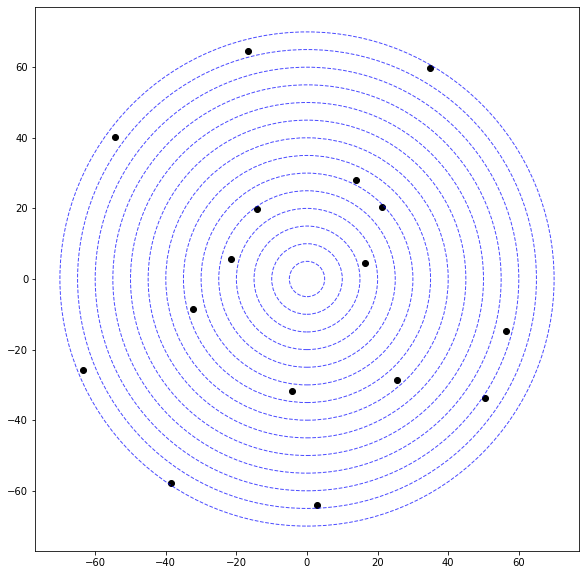

In [9]:
import matplotlib.pyplot as plt
positions = generate_ncoords_by_azimuth_bins(16)
plt.rcParams["figure.figsize"] = (10,10)

fig, ax = plt.subplots()
plt.gca().set_aspect('equal', adjustable='box')
ax.scatter(positions[:,0], positions[:,1], color='black')

circle_binsize=5
num_circles = int(np.ceil(70/circle_binsize))
for i in range(1, num_circles+1):
    circle = plt.Circle((0, 0), circle_binsize*i, color='b', fill=False, alpha=0.7, linestyle='--')
    ax.add_patch(circle)

# Object orientation

In [19]:
pts = load_shapenet(obj_file, num_pts=300000)

In [25]:
# Rotate the object in 8 directions
num_orientations = 8
yaw_inc = 2*np.pi/num_orientations
yaw = -2*np.pi+yaw_inc*7

# Method 2: -sin at index [0,1] and pre-multiply
rot_matrix = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                      [np.sin(yaw), np.cos(yaw), 0],
                      [0, 0, 1]])
rot_pts = (rot_matrix @ pts.T).T # anti-clockwise rotation following RH Coordinate system 

# Method 2: -sin at index [1,0] and post-multiply
rot_matrix2 = np.array([[np.cos(yaw), np.sin(yaw), 0],
                      [-np.sin(yaw), np.cos(yaw), 0],
                      [0, 0, 1]])
rot_pts2 = pts @ rot_matrix2 # anti-clockwise rotation following RH Coordinate system 

# Note that these two are the same

o3d.visualization.draw_geometries([convert_to_o3dpcd(pts, color=[0.85,0.85,0.85]), convert_to_o3dpcd(rot_pts2)])

# Putting it all together in our 3D world

In [128]:
# Params
num_orientations = 8
num_azbins = 8

# Load points of a single model
model_pts = load_shapenet(obj_file, num_pts=300000)

rot_objs = []
bboxes = []

# For each of the 8 orientations, scale them differently
yaw_inc = 2*np.pi/num_orientations
yaws = np.array([i*yaw_inc for i in range(num_orientations)])
yaws[yaws > np.pi] += -2*np.pi # convert to the range [-np.pi, np.pi]

for i in range(num_orientations):
    
    yaw = yaws[i]
    alpha = get_scaling_factor(model_pts)
    scaled_pts = alpha * model_pts
    rot_matrix = np.array([[np.cos(yaw), np.sin(yaw), 0],
                          [-np.sin(yaw), np.cos(yaw), 0],
                          [0, 0, 1]])
    rot_pts = scaled_pts @ rot_matrix # anti-clockwise rotation following RH Coordinate system 
    gtbox = get_gt_for_zero_yaw(scaled_pts)
    
    # Scale    
    obj_data = {'bbox': gtbox['bbox'] @ rot_matrix,
                'pts': rot_pts,
                'heading': yaw,
                'dims': gtbox['dims']}
    rot_objs.append(obj_data)

# Translate
# Every centroid location, has 8 views
dataset = []
centroids = generate_ncoords_by_azimuth_bins(nbins=num_azbins)
for centroid in centroids:
    for obj in rot_objs:
        translated_obj = {}  
        translated_obj['centroid'] = centroid
        translated_obj['pts'] = obj['pts'] + centroid
        translated_obj['bbox'] = obj['bbox'] + centroid
        translated_obj['heading'] = obj['heading']
        translated_obj['dims'] = obj['dims']
        dataset.append(translated_obj)

Text(0.5, 1.0, 'BEV positions of views for a single object model (10m rings)')

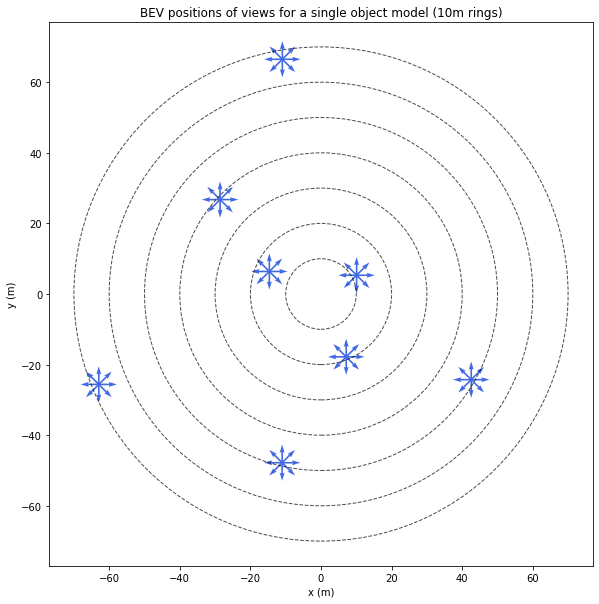

In [129]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

fig, ax = plt.subplots()
plt.gca().set_aspect('equal', adjustable='box')

q = np.array([[1,0],
             [0,1],
             [0,-1],             
             [-1,0],
             [np.cos(np.pi/4),np.cos(np.pi/4)],
             [np.cos(np.pi/4),-np.cos(np.pi/4)],
             [-np.cos(np.pi/4),-np.cos(np.pi/4)],
             [-np.cos(np.pi/4),np.cos(np.pi/4)]])

for centroid in centroids:
    ax.quiver(centroid[0]*np.ones([8]),centroid[1]*np.ones([8]),q[:,0],q[:,1], width=0.003, color='royalblue', scale=30)

circle_binsize=10
num_circles = int(np.ceil(70/circle_binsize))
for i in range(1, num_circles+1):
    circle = plt.Circle((0, 0), circle_binsize*i, color='black', fill=False, alpha=0.7, linestyle='--')
    ax.add_patch(circle)
    
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_title('BEV positions of views for a single object model (10m rings)')

# Scan pattern simulation

## Method 1: pcd.hidden_point_removal and DIY raycasting

In [10]:
pcd = convert_to_o3dpcd(data['pts'])
lidar_position = [0,0,1.8]
radius = data['dims']['length']*10000
tmesh, pt_map = pcd.hidden_point_removal(lidar_position, radius)
lidarvp = pcd.select_by_index(pt_map)

lidar_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=lidar_position )
o3d.visualization.draw_geometries([lidarvp, lidar_origin])

NameError: name 'data' is not defined

(array([3938., 2717., 2658., 7300., 4519., 3237., 2554., 1852., 2145.,
         959.]),
 array([1.579766  , 1.58940573, 1.59904545, 1.60868517, 1.61832489,
        1.62796461, 1.63760433, 1.64724405, 1.65688377, 1.6665235 ,
        1.67616322]),
 <BarContainer object of 10 artists>)

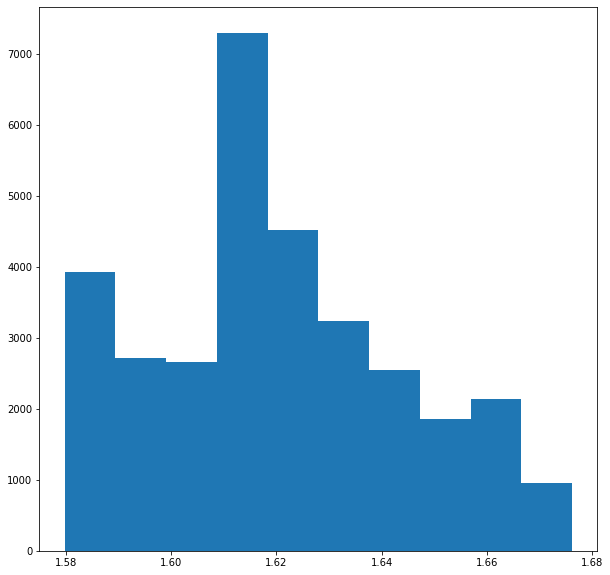

In [315]:
pts = np.asarray(np.asarray(lidarvp.points) + [0,0,-1.8])
sph = cart2sph(pts) # r, azimuth, elevation
plt.hist(sph[:,2])

It's super challenging to recreate the lidar point cloud by just fixing the hres and vres since that's not really how the lidars work. The KITTI velodyne vertical angle goes up in a weird seasonal-like movement.  So I think I'll either use the ray casting or the virtual lidar. I can test both I guess. 

Maybe the raycasting first, then if it's good, I'll test the virtual since I think virtual is harder due to noisy point sampling. For virtual, we can get 50 frames of waymo, nusc, kitti and baraja for training. 

In [445]:
# vres = 0.4 * np.pi/180
num_vbins = 64
# hres = 0.08 * np.pi/180 # 0.08 - 0.35
hres = 0.00043344
# vfov_bounds = np.array([-24.9, 2.0]) * np.pi/180

lidar_minvfov = 2 # deg
lidar_maxvfov = -24.9 # deg -24.9

# Spherical coordinates define elevation angle from z-axis as 0 and xy-plane as 90.
# Lidar fov angles are given with x-axis as 0 angle so we add 90 deg.
vfov_bounds = np.array([90-lidar_minvfov, 90-lidar_maxvfov]) * np.pi/180 
vfov = abs(max(vfov_bounds) - min(vfov_bounds))
hfov = 360 * np.pi/180

# we can determine vres with rings, or rings with vres. But since rings are usually fixed, we'll use rings.
# ring = num_vbins
vres = vfov/num_vbins
num_hbins = int(hfov/hres)

vbins = [min(vfov_bounds) + i*vres for i in range(num_vbins+1)]
hbins = np.array([-np.pi + i*hres for i in range(num_hbins+1)]) # range [-pi, +pi]

In [450]:
vidx = np.digitize(sph[:,2], vbins)[...,np.newaxis]
hidx = np.digitize(sph[:,1], hbins)[...,np.newaxis]
sph_quantized = np.hstack([sph, vidx, hidx])

In [453]:
# From https://nbviewer.org/github/balzer82/3D-OccupancyGrid-Python/blob/master/3D-Occupancy-Grid-ibeo-Lux.ipynb

new_array = [tuple(row[3:]) for row in sph_quantized]
uniques, indices = np.unique(new_array, axis=0, return_index=True)
sph_unique = sph_quantized[indices]

azimuth = sph_unique[:,1]
dist = sph_unique[:,0]
vlayer = sph_unique[:,3]
hlayer = sph_unique[:,4]

phi = vlayer * vres
azimuth = hlayer * hres
x = dist * np.cos(azimuth)
y = dist * np.sin(azimuth)
z = -dist * np.sin(phi)

sim_pts = np.array([x,y,z]).T
print(len(sim_pts))

3814


In [455]:
o3d.visualization.draw_geometries([convert_to_o3dpcd(sim_pts), lidar_origin])

## Method 1.5 Virtual Lidar

If using virtual lidar, we need to shift the coordinate of the objects to fit with the sampled azimuth/elevation of the datasets. I.e. for KITTI we need to add [0,0,-1.8]

In [506]:
pcd = convert_to_o3dpcd(data['pts'] + [0,0,-1.8])
lidar_position = [0,0,0]
radius = data['dims']['length']*10000
tmesh, pt_map = pcd.hidden_point_removal(lidar_position, radius)
lidarvp = pcd.select_by_index(pt_map)

lidar_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=lidar_position )
o3d.visualization.draw_geometries([lidarvp, lidar_origin])

In [526]:
from sklearn.neighbors import NearestNeighbors
import time

ref_pattern_paths = glob.glob(f'/SEE-MTDA/data/shapenet/pcn/ref_pattern_kitti-kitti/*.npy')
ref_patterns = [np.load(path) for path in ref_pattern_paths]
print(len(ref_patterns))

t0 = time.time()
reference_phi_theta = ref_patterns[20] # stick with using just 1 ref frame. Any more and you see no more rings

pts = np.asarray(np.asarray(lidarvp.points))
sph = cart2sph(pts) # r, azimuth, elevation

X = sph[:,1:3]
Y = reference_phi_theta
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(Y)
indices = indices[:,0]
distances = distances[:,0]

filt_indices = indices[np.where(distances < 0.001)]
dense_filt = sph[filt_indices]
sampled_obj = sph2cart(dense_filt)

print(time.time() - t0) 

sampled_pcd = convert_to_o3dpcd(sampled_obj)
lidarpcd.paint_uniform_color([0.85, 0.85, 0.85])
o3d.visualization.draw_geometries([sampled_pcd])

50
0.28844261169433594


In [527]:
# Get 100 ref frames from baraja, kitti, waymo, nusc 
# randomly choose out of the 100*4 frames when sampling for each pose.
# for Baraja cause it's an FOV-limited lidar, only use it when the car is in the azimuth range.
# make sure to also change frame of ref (i.e. +[0,0,-1.8]) if need be for waymo.

## Method 2: Raycasting but with no flexibility of sampling vres/hres

The raycasted points have an even spacing vertically and horizontally. You can change this spacing by varying the FOV from 90 to 179. If you do 180, it'll be empty. Same with changing width. Height of image doesn't change spacing but rather the vertical fov. 

In [70]:
def load_shapenet_to_tmesh(obj_file):
    v,f,n = pcu.load_mesh_vfn(obj_file)
    
    # Shapenet forward is -z, here we change to +z to fit right hand rule convention (convention for most lidars)
    # Detection datasets define car length as x, width as y, and height as z. Forward is +x
    v[:,2] *= -1
    
    # Here we re-orient shapenet coordinate system of [z,x,y] to fit typical lidar convention of [x,y,z]
    v = v[:,[2,0,1]]     
    
    alpha = get_scaling_factor(v)
    scaled = alpha * v
    
    loaded_tmesh = o3d.geometry.TriangleMesh()
    loaded_tmesh.vertices = o3d.utility.Vector3dVector(scaled)
    loaded_tmesh.triangles = o3d.utility.Vector3iVector(f)
    return loaded_tmesh

centroids = generate_ncoords_by_azimuth_bins(nbins=16, max_dist=30)

In [200]:
models = glob.glob(f'/SEE-MTDA/data/shapenet/ShapeNetCore.v2/{cat2id["car"]}/*')


In [219]:
mids = [mod.split('/')[-1] for mod in models]
mids.index("74f7b559d6af926012f2e446484bbaf7")

57

In [256]:
model_idx = 57
obj_file = models[model_idx] + '/models/model_normalized.obj'
tmesh = load_shapenet_to_tmesh(obj_file)
v_np = np.asarray(tmesh.vertices)
print(f'length = {max(v_np[:,0]) - min(v_np[:,0])}')
print(f'width = {max(v_np[:,1]) - min(v_np[:,1])}')
print(f'height = {max(v_np[:,2]) - min(v_np[:,2])}')
# o3d.visualization.draw_geometries([tmesh])

yaw = 180 * np.pi/180
rot_matrix = np.array([[np.cos(yaw), np.sin(yaw), 0],
                      [-np.sin(yaw), np.cos(yaw), 0],
                      [0, 0, 1]])

tmesh.vertices = o3d.utility.Vector3dVector(tmesh.vertices @ rot_matrix.T + np.asarray([10,0, -1.1]))
print(f'center at {tmesh.get_center()}')
print(f'distance: {np.linalg.norm(tmesh.get_center())}')

length = 4.626490175811201
width = 1.9318119224847057
height = 1.5538351416464717
center at [ 9.99999998e+00  1.45277594e-09 -1.10000003e+00]
distance: 10.060318071043186


In [257]:
# o3d.visualization.draw_geometries([tmesh.sample_points_uniformly(16384)])

In [258]:
# gtbox=[4.540924858526304, 2.8169682383594665, -1.0173497387569825, 4.502861211469725, 1.880190088609867, 1.5123135946380073, -2.356194490192345]
# en(points) = 20147;
# adjusted fov_mean=170-fov_deg=138.16002359582149
# aspect_ratio=3
# model_id=74f7b559d6af926012f2e446484bbaf7

In [259]:
yaw_inc = 2*np.pi/8
yaws = np.array([i*yaw_inc * (180/np.pi) for i in range(num_orientations)])
yaws

array([  0.,  45.,  90., 135., 180., 225., 270., 315.])

In [260]:
scene = o3d.t.geometry.RaycastingScene()
_ = scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(tmesh))
lidar_position = [0,0,0]
aspect_ratio = 3 # keep this aspect ratio I think
height_px = 640

# fix height at 640, aspect ratio at 2
# randomly choose fov_deg in [90,150] as this changes "rings" somewhat

fov_deg = np.random.randint(90,150)
print(f'Casting ray at fov: {fov_deg} deg')

rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
    fov_deg=120, # vertical fov
    center=tmesh.get_center(),
    eye=lidar_position,
    up=[0, 0, 1],
    width_px=aspect_ratio*height_px,
    height_px=height_px,
)
# We can directly pass the rays tensor to the cast_rays function.
ans = scene.cast_rays(rays)
hit = ans['t_hit'].isfinite()
points = rays[hit][:,:3] + rays[hit][:,3:]*ans['t_hit'][hit].reshape((-1,1))
print(f'num pts = {len(points.numpy())}')

Casting ray at fov: 92 deg
num pts = 9391


In [262]:
sph_pts = cart2sph(points.numpy())
sph_pts[:,0] +=  np.random.normal(0,0.01,len(points))
lidar_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=lidar_position )
o3d.visualization.draw_geometries([convert_to_o3dpcd(sph2cart(sph_pts)),lidar_origin])

In [178]:
noise_stdev = 0.001 # visually confirmed
awgn = np.random.normal(0,noise_stdev,[len(points),3]) # additive white gauss noise
pcd = o3d.t.geometry.PointCloud(points.numpy()+awgn)

lidar_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=lidar_position )
o3d.visualization.draw_geometries([pcd.to_legacy(),lidar_origin])

# Final Code: Export with Ray casting method

In [2]:
def load_shapenet(obj_file):
    v,f,n = pcu.load_mesh_vfn(obj_file)
    
    # Shapenet forward is -z, here we change to +z to fit right hand rule convention (convention for most lidars)
    # Detection datasets define car length as x, width as y, and height as z. Forward is +x
    v[:,2] *= -1
    
    # Here we re-orient shapenet coordinate system of [z,x,y] to fit typical lidar convention of [x,y,z]
    v = v[:,[2,0,1]]     
    
    # ShapeNet is centered but it's slightly off 0,0,0
    bounds = get_minmax(v)
    center = np.array([(bounds['max_x']+bounds['min_x'])/2, 
                       (bounds['max_y']+bounds['min_y'])/2, 
                       (bounds['max_z']+bounds['min_z'])/2]) 
    return v - center, f

# Load shapenet
cat2id = {}
with open("/SEE-MTDA/data/shapenet/synsetoffset2category.txt", "r") as f:
    lines = csv.reader(f,delimiter='\t')
    for line in lines:
        cat2id[line[0]] = line[1]
        
        
cat = 'car'
models = glob.glob(f'/SEE-MTDA/data/shapenet/ShapeNetCore.v2/{cat2id["car"]}/*')
print(len(models))

3533


In [323]:
partial_path = glob.glob('/SEE-MTDA/data/shapenet/VC/WAYMO_t-2768_nviews-30/train/partial/*/*.pcd')
complete_path = glob.glob('/SEE-MTDA/data/shapenet/VC/WAYMO_t-2768_nviews-30/train/complete/*/*.pcd')
label_path = glob.glob('/SEE-MTDA/data/shapenet/VC/WAYMO_t-2768_nviews-30/train/label/*/*.pkl')

In [332]:
i = 97
partial = o3d.io.read_point_cloud(partial_path[i])
complete = o3d.io.read_point_cloud(complete_path[i])

with open(label_path[i], 'rb') as f:
    label = pickle.load(f)
    
print(label)
complete.paint_uniform_color([0.9,0.9,0.9])
o3d.visualization.draw_geometries([partial, complete, boxpts_to_o3dbox(label['bbox_pts'])])

{'bbox_pts': array([[-17.23941114,  28.75358616,  -1.57236448],
       [-18.13959998,  30.03868968,  -1.57236448],
       [-14.31828483,  30.79977562,  -1.57236448],
       [-15.21847368,  32.08487915,  -1.57236448],
       [-17.23941114,  28.75358616,  -2.66040874],
       [-18.13959998,  30.03868968,  -2.66040874],
       [-14.31828483,  30.79977562,  -2.66040874],
       [-15.21847368,  32.08487915,  -2.66040874]]), 'gtbox': [-16.32773902850431, 30.350674666922487, -2.368247363148123, 3.5664927052620845, 1.5690223168500996, 1.088044260025101, 2.5305448640388315], 'pc_id': 'c00e0066715c2226921cb81cb1632a5e_000', 'raycasting': 120.02287082331769}


In [7]:
import numpy as np

datalen = 2768*30
batch_size = 32
iter_per_s = 3
training_time = ((datalen/batch_size)/iter_per_s)/60
print(f'dataset length: {datalen} - {training_time:0.2f} mins per epoch')

num_epochs = 100
hrs = np.floor((training_time * num_epochs)/60)
mins = (training_time * num_epochs) % 60
print(f'{int(hrs)}HRS {mins:0.2f}MINS for {num_epochs} epochs')

dataset length: 83040 - 14.42 mins per epoch
24HRS 1.67MINS for 100 epochs


In [4]:
test = 354
val = 354
train = 3533-test-val
train

2825

In [24]:
from tqdm import tqdm
from pathlib import Path
import pickle

# For reference: PCN reserves 100 models for validation and 150 for testing

# Params
num_orientations = 16
num_azbins = 8 # aka. Allocentric rotation (angle of object from lidar view)
npoints_complete = 16384

# experiment dataset size
# exp_size = 50 # 10 models * 8 * 16 views
# model_subset = models[:exp_size]

# test = 354
# val = 354
# train = 3533-test-val
model_subset = models[800:880]
dataset_name = 'val'

# model_subset = models
print(f'Generating views for {len(model_subset)} models')

# Full - use random point drop to reduce min_pts rather than here. 
# We limit max points to reduce unrealistic point density (same max_pts as PCN)
cfg = { 'min_pts': 50,
        'max_pts': 2048, 
        'min_dist': 5,
        'max_dist': 50,             
        'fov_deg': 'normal',
        'lidar_position': [0,0,0],
        'centroid_offset': [0,0,-1.8],
        'translate': True,
        'scaled': True }

cfg = cfg

save_dir = Path(f'/SEE-MTDA/data/shapenet/VC/800t_80v_8-16/{dataset_name}')
save_dir.mkdir(exist_ok=True, parents=True)

# # non-translated
# cfg = { 'min_pts': 100,
#         'max_pts': 2048, 
#         'fov_deg': 'normal',
#         'lidar_position': [5,0,1.8],
#         'centroid_offset': [0,0,0],
#         'translate': False,
#         'scaled': True}

# non-translated, non-scaled
# cfg = { 'min_pts': 100,
#         'fov_deg': 150,
#         'lidar_position': [1,0,1],
#         'centroid_offset': [0,0,0],
#         'translate': False,
#         'scaled': False}

Generating views for 80 models


In [25]:
# Some shapenet models have no obj files and so we 
# may end up less than the specified amount

for model_idx in tqdm(range(len(model_subset)), total=len(model_subset)):
    model_dataset = []

    # Load points of a single model
    model_id = model_subset[model_idx].split('/')[-1]
    obj_file = model_subset[model_idx] + '/models/model_normalized.obj'
    if not Path(obj_file).exists():
        continue 

    model_v, model_f = load_shapenet(obj_file)

    rot_objs = []
    bboxes = []

    # For each of the orientations, scale them differently
#     yaw_inc = 2*np.pi/num_orientations
#     yaws = np.array([i*yaw_inc for i in range(num_orientations)])
    yaws = np.random.uniform(-np.pi, np.pi, num_orientations)
#     yaws[yaws > np.pi] += -2*np.pi # convert to the range [-np.pi, np.pi]

    for i in range(num_orientations):

        yaw = yaws[i]
        if cfg['scaled']:
            alpha = get_scaling_factor(model_v)
            scaled_pts = alpha * model_v
        else:
            scaled_pts = model_v

        rot_matrix = np.array([[np.cos(yaw), np.sin(yaw), 0],
                              [-np.sin(yaw), np.cos(yaw), 0],
                              [0, 0, 1]])
        rot_pts = scaled_pts @ rot_matrix # anti-clockwise rotation following RH Coordinate system 
        gtbox = get_gt_for_zero_yaw(scaled_pts)

        # Scale    
        obj_data = {'bbox': gtbox['bbox'] @ rot_matrix,
                    'pts': rot_pts,
                    'heading': yaw,
                    'dims': gtbox['dims']}
        rot_objs.append(obj_data)

    # Translate
    # Every centroid location, has 8 views    
    # Fixed lidar position at (0,0,0) (but we also vary centroid z so it's not too bad)        
    # Spherical coordinates have azimuth/elevation computed from (0,0,0) so we can properly isolate
    # lidar rings by spherical coordinate elevation if we have lidar rays coming from (0,0,0)
    if cfg['translate']:
        centroids = generate_ncoords_by_azimuth_bins(nbins=num_azbins, min_dist=cfg['min_dist'], max_dist=cfg['max_dist']) 
    else:
        centroids = np.zeros([num_azbins,3])

    for centroid in centroids:                
        centroid += cfg['centroid_offset']
        for obj in rot_objs:
            translated_obj = {}  
            translated_obj['bbox_pts'] = obj['bbox'] + centroid

            # gtboxes are (N,7) [x,y,z,dx,dy,dz,heading]
            translated_obj['gtbox'] = list(centroid) + list(obj['dims']) + list([obj['heading']])

            tmesh = o3d.geometry.TriangleMesh()
            tmesh.vertices = o3d.utility.Vector3dVector(obj['pts'] + centroid)
            tmesh.triangles = o3d.utility.Vector3iVector(model_f)
            translated_obj['mesh'] = tmesh
            translated_obj['model_id'] = model_id
            translated_obj['complete'] = tmesh.sample_points_uniformly(npoints_complete)

            model_dataset.append(translated_obj)
    
    for data in model_dataset:

        scene = o3d.t.geometry.RaycastingScene()
        tmesh = data['mesh']
        _ = scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(tmesh))
        aspect_ratio = 2
        height_px = 640

        points = np.array([])
        valid = False
        if cfg['fov_deg'] == 'normal':
            fov_mean = 120
            fov_stdev = 15
        else:
            fov_mean = cfg['fov_deg']
                        
        attempt = 0
        while(valid == False):         

            if cfg['fov_deg'] == 'normal':
                fov_deg = np.random.normal(fov_mean, fov_stdev)
            else:
                fov_deg = fov_mean

            rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
                fov_deg=fov_deg, # vertical fov
                center=tmesh.get_center(),
                eye=cfg['lidar_position'],
                up=[0, 0, 1],
                width_px=aspect_ratio*height_px,
                height_px=height_px,
            )
            # We can directly pass the rays tensor to the cast_rays function.
            ans = scene.cast_rays(rays)
            hit = ans['t_hit'].isfinite()
            points = rays[hit][:,:3] + rays[hit][:,3:]*ans['t_hit'][hit].reshape((-1,1))  
            points = points.numpy()            

            if (len(points) < cfg['min_pts']):                
                if np.random.choice([True, False]):
                    new_fov = fov_mean - 5
                    fov_mean = max(90, new_fov)
                else:
                    aspect_ratio += 1                      
            elif (len(points) > cfg['max_pts']):                    
                if np.random.choice([True, False]):
                    new_fov = fov_mean + 5
                    fov_mean = min(160, new_fov)
                else:
                    new_heightpx = height_px - 20
                    height_px = max(40, new_heightpx)
            else:
                valid = True
            attempt += 1
            if attempt > 10:
                print(f'\ngtbox={data["gtbox"]}\nlen(points) = {len(points)};\nadjusted fov_mean={fov_mean}-fov_deg={fov_deg}\naspect_ratio={aspect_ratio}\nmodel_id={data["model_id"]}')              

        # Export without white noise but we can add it during training time
        data['partial'] = convert_to_o3dpcd(points)
        data['raycasting'] = {'fov': fov_deg, 'height_px': height_px, 'aspect_ratio': aspect_ratio}

    # Save partial, complete, labels
    partial_dir = save_dir / 'partial' / model_id
    partial_dir.mkdir(exist_ok=True, parents=True)

    complete_dir = save_dir / 'complete' / model_id
    complete_dir.mkdir(exist_ok=True, parents=True)

    label_dir = save_dir / 'label' / model_id
    label_dir.mkdir(exist_ok=True, parents=True)
    for idx, data in enumerate(model_dataset):
        o3d.io.write_point_cloud(str(partial_dir / f'{idx:03d}.pcd'), data['partial'])
        o3d.io.write_point_cloud(str(complete_dir / f'{idx:03d}.pcd'), data['complete'])
        with open(str(label_dir / f'{idx:03d}.pkl'), 'wb') as f:
            label = {'bbox_pts': data['bbox_pts'], 
                     'gtbox': data['gtbox'],
                     'pc_id': f'{model_id}_{idx:03d}',
                     'raycasting': data['raycasting']}
            pickle.dump(label, f)

# Chown             
import os

os.system(f"cd {str(save_dir)} && ls complete > model_ids.txt")
os.system(f"cd {str(save_dir.parent)} && chown -R 1005:1005 {str(save_dir.stem)}")

  0%|                                                        | 0/80 [00:00<?, ?it/s]


gtbox=[-3.133482519984698, 6.441077223662305, -1.0625652773414498, 6.936389309683297, 2.000662775309377, 1.5409695577715812, -1.8464364707186953]
len(points) = 11259;
adjusted fov_mean=145-fov_deg=115.21845734495861
aspect_ratio=2
model_id=d5f1637a5c9479e0185ce5d54f27f6b9

gtbox=[-3.133482519984698, 6.441077223662305, -1.0625652773414498, 6.936389309683297, 2.000662775309377, 1.5409695577715812, -1.8464364707186953]
len(points) = 4028;
adjusted fov_mean=145-fov_deg=136.966413127554
aspect_ratio=2
model_id=d5f1637a5c9479e0185ce5d54f27f6b9

gtbox=[-3.133482519984698, 6.441077223662305, -1.0625652773414498, 6.936389309683297, 2.000662775309377, 1.5409695577715812, -1.8464364707186953]
len(points) = 2816;
adjusted fov_mean=150-fov_deg=142.1943961679248
aspect_ratio=2
model_id=d5f1637a5c9479e0185ce5d54f27f6b9

gtbox=[-3.133482519984698, 6.441077223662305, -1.0625652773414498, 6.936389309683297, 2.000662775309377, 1.5409695577715812, -1.8464364707186953]
len(points) = 94;
adjusted fov_mean=

  1%|▌                                               | 1/80 [00:27<36:15, 27.54s/it]


gtbox=[-7.272399427803378, -3.997184390890558, -0.9843140902466552, 8.958365163013074, 2.140924715415486, 2.283380366194115, 1.2324625893210461]
len(points) = 8576;
adjusted fov_mean=135-fov_deg=138.00336615915865
aspect_ratio=2
model_id=fd3b75f7f1e9172fb6f657757c95f74e

gtbox=[-7.272399427803378, -3.997184390890558, -0.9843140902466552, 8.958365163013074, 2.140924715415486, 2.283380366194115, 1.2324625893210461]
len(points) = 12602;
adjusted fov_mean=135-fov_deg=130.0827529707146
aspect_ratio=2
model_id=fd3b75f7f1e9172fb6f657757c95f74e

gtbox=[-7.272399427803378, -3.997184390890558, -0.9843140902466552, 8.958365163013074, 2.140924715415486, 2.283380366194115, 1.2324625893210461]
len(points) = 3242;
adjusted fov_mean=140-fov_deg=152.2949930034977
aspect_ratio=2
model_id=fd3b75f7f1e9172fb6f657757c95f74e

gtbox=[-7.272399427803378, -3.997184390890558, -0.9843140902466552, 8.958365163013074, 2.140924715415486, 2.283380366194115, 1.2324625893210461]
len(points) = 5672;
adjusted fov_mean=1


gtbox=[-7.272399427803378, -3.997184390890558, -0.9843140902466552, 8.928438764613686, 2.133772722299471, 2.2757524843995443, -1.3209631459031588]
len(points) = 5437;
adjusted fov_mean=150-fov_deg=142.94792633604237
aspect_ratio=2
model_id=fd3b75f7f1e9172fb6f657757c95f74e

gtbox=[-7.272399427803378, -3.997184390890558, -0.9843140902466552, 8.928438764613686, 2.133772722299471, 2.2757524843995443, -1.3209631459031588]
len(points) = 5860;
adjusted fov_mean=150-fov_deg=141.53325521910656
aspect_ratio=2
model_id=fd3b75f7f1e9172fb6f657757c95f74e

gtbox=[-7.272399427803378, -3.997184390890558, -0.9843140902466552, 8.928438764613686, 2.133772722299471, 2.2757524843995443, -1.3209631459031588]
len(points) = 2670;
adjusted fov_mean=155-fov_deg=152.30176685469968
aspect_ratio=2
model_id=fd3b75f7f1e9172fb6f657757c95f74e

gtbox=[-7.272399427803378, -3.997184390890558, -0.9843140902466552, 8.928438764613686, 2.133772722299471, 2.2757524843995443, -1.3209631459031588]
len(points) = 4627;
adjusted f


gtbox=[-5.3742916882547735, 4.809122958030213, -1.2056187088783532, 8.00814441350926, 1.913835168305631, 2.041180437581527, 1.0280598130028284]
len(points) = 3652;
adjusted fov_mean=160-fov_deg=152.70484801013103
aspect_ratio=2
model_id=fd3b75f7f1e9172fb6f657757c95f74e

gtbox=[-5.3742916882547735, 4.809122958030213, -1.2056187088783532, 8.00814441350926, 1.913835168305631, 2.041180437581527, 1.0280598130028284]
len(points) = 2557;
adjusted fov_mean=160-fov_deg=157.12810563495378
aspect_ratio=2
model_id=fd3b75f7f1e9172fb6f657757c95f74e

gtbox=[-5.3742916882547735, 4.809122958030213, -1.2056187088783532, 8.00814441350926, 1.913835168305631, 2.041180437581527, 1.0280598130028284]
len(points) = 20;
adjusted fov_mean=160-fov_deg=182.05527520937306
aspect_ratio=3
model_id=fd3b75f7f1e9172fb6f657757c95f74e

gtbox=[-5.3742916882547735, 4.809122958030213, -1.2056187088783532, 8.00814441350926, 1.913835168305631, 2.041180437581527, 1.0280598130028284]
len(points) = 1615;
adjusted fov_mean=160-fo

  2%|█▏                                              | 2/80 [01:46<55:45, 42.89s/it]


gtbox=[4.8293225385284275, -5.2036644054682, -1.158496065372438, 4.979397429618989, 2.012468377314988, 1.5390371106410883, -2.625400982431228]
len(points) = 8567;
adjusted fov_mean=140-fov_deg=129.80184510953828
aspect_ratio=2
model_id=982448cbcbe56bb78f89cf8d2f8a85b0

gtbox=[4.8293225385284275, -5.2036644054682, -1.158496065372438, 4.979397429618989, 2.012468377314988, 1.5390371106410883, -2.625400982431228]
len(points) = 12596;
adjusted fov_mean=140-fov_deg=118.83034966546323
aspect_ratio=2
model_id=982448cbcbe56bb78f89cf8d2f8a85b0

gtbox=[4.8293225385284275, -5.2036644054682, -1.158496065372438, 4.979397429618989, 2.012468377314988, 1.5390371106410883, -2.625400982431228]
len(points) = 5235;
adjusted fov_mean=140-fov_deg=136.7317049669052
aspect_ratio=2
model_id=982448cbcbe56bb78f89cf8d2f8a85b0

gtbox=[4.8293225385284275, -5.2036644054682, -1.158496065372438, 4.979397429618989, 2.012468377314988, 1.5390371106410883, -2.625400982431228]
len(points) = 2850;
adjusted fov_mean=140-fov_

  4%|█▊                                              | 3/80 [02:11<48:17, 37.63s/it]


gtbox=[2.341696747135907, -5.448221653491241, -0.7657440721043132, 4.601727866779784, 2.0661505818552324, 1.4265122064203821, -1.685908858365763]
len(points) = 1015;
adjusted fov_mean=145-fov_deg=161.81830764068616
aspect_ratio=2
model_id=60d8d7776789b4b1fe11eeaa72c8aa36

gtbox=[2.341696747135907, -5.448221653491241, -0.7657440721043132, 4.786116993565292, 2.1489402888142086, 1.483671896803114, 1.5136624739186573]
len(points) = 4196;
adjusted fov_mean=135-fov_deg=141.092961965484
aspect_ratio=2
model_id=60d8d7776789b4b1fe11eeaa72c8aa36

gtbox=[2.341696747135907, -5.448221653491241, -0.7657440721043132, 4.786116993565292, 2.1489402888142086, 1.483671896803114, 1.5136624739186573]
len(points) = 10461;
adjusted fov_mean=135-fov_deg=121.72754092986432
aspect_ratio=2
model_id=60d8d7776789b4b1fe11eeaa72c8aa36

gtbox=[2.341696747135907, -5.448221653491241, -0.7657440721043132, 4.786116993565292, 2.1489402888142086, 1.483671896803114, 1.5136624739186573]
len(points) = 8363;
adjusted fov_mean=

  8%|███▌                                            | 6/80 [03:34<37:28, 30.39s/it]


gtbox=[-1.7736259088191475, 5.767674935845971, -1.181725400864773, 3.96899786975692, 1.8403187862018453, 1.212271792750512, 2.468154194907161]
len(points) = 342;
adjusted fov_mean=145-fov_deg=166.9289125272767
aspect_ratio=2
model_id=692001fd91d8328ef421855cd210fbe9

gtbox=[-1.7736259088191475, 5.767674935845971, -1.181725400864773, 4.2874888971999905, 1.9879946077250514, 1.3095501742168667, 1.6600279292059144]
len(points) = 1681;
adjusted fov_mean=145-fov_deg=151.3900007994656
aspect_ratio=2
model_id=692001fd91d8328ef421855cd210fbe9

gtbox=[-1.7736259088191475, 5.767674935845971, -1.181725400864773, 3.9212803704743617, 1.818193450476824, 1.197697187195387, 2.613398494404806]
len(points) = 1971;
adjusted fov_mean=135-fov_deg=147.28998992371731
aspect_ratio=2
model_id=692001fd91d8328ef421855cd210fbe9


 15%|███████                                        | 12/80 [05:50<25:43, 22.70s/it]


gtbox=[-2.6015062520677747, -9.02434014931636, -1.1625137332663011, 5.134949793370229, 2.0704756981510797, 1.4450974618046972, 0.2222832500416385]
len(points) = 851;
adjusted fov_mean=155-fov_deg=156.78976783291193
aspect_ratio=2
model_id=9c686d6ec470f280473f10e6caaeca56

gtbox=[-2.6015062520677747, -9.02434014931636, -1.1625137332663011, 4.503179617212487, 1.8157380961904754, 1.2673022515792338, 2.96025327760069]
len(points) = 877;
adjusted fov_mean=140-fov_deg=149.7538195985788
aspect_ratio=2
model_id=9c686d6ec470f280473f10e6caaeca56


 16%|███████▋                                       | 13/80 [06:11<24:48, 22.21s/it]


gtbox=[3.9907349315246163, -6.659848666695135, -0.4058588836531911, 3.7892232709324483, 1.9056458012434487, 1.9720753147526235, 2.0584531457727975]
len(points) = 107;
adjusted fov_mean=150-fov_deg=188.44274499571432
aspect_ratio=2
model_id=8285dfa786cf25b2c29fde65e51f52cb

gtbox=[3.9907349315246163, -6.659848666695135, -0.4058588836531911, 3.8660620243852133, 1.944288931357555, 2.012065518038605, 0.0715072346871497]
len(points) = 3064;
adjusted fov_mean=145-fov_deg=143.85750827063575
aspect_ratio=2
model_id=8285dfa786cf25b2c29fde65e51f52cb

gtbox=[3.9907349315246163, -6.659848666695135, -0.4058588836531911, 3.8660620243852133, 1.944288931357555, 2.012065518038605, 0.0715072346871497]
len(points) = 2817;
adjusted fov_mean=145-fov_deg=145.19894226963214
aspect_ratio=2
model_id=8285dfa786cf25b2c29fde65e51f52cb

gtbox=[3.9907349315246163, -6.659848666695135, -0.4058588836531911, 3.8660620243852133, 1.944288931357555, 2.012065518038605, 0.0715072346871497]
len(points) = 3833;
adjusted fov_

 19%|████████▊                                      | 15/80 [07:09<26:58, 24.90s/it]


gtbox=[38.90085907980259, 15.671025381539511, -1.3607480889311, 2.2271528122410347, 1.8231420445784892, 0.15949249942207133, 1.3459181893921048]
len(points) = 148;
adjusted fov_mean=90-fov_deg=74.95862234547835
aspect_ratio=6
model_id=504793ed2da6cf7eba3e2415e22cd45c


 29%|█████████████▌                                 | 23/80 [10:30<16:18, 17.17s/it]


gtbox=[-6.031679191662997, -7.072807702111753, -0.6634828700394879, 7.123284265854343, 1.9633704342960079, 1.505065669361058, 2.065895902506356]
len(points) = 6399;
adjusted fov_mean=145-fov_deg=117.29075611457876
aspect_ratio=2
model_id=b8599e22b152b96e55e3ad998a1ecb4

gtbox=[-6.031679191662997, -7.072807702111753, -0.6634828700394879, 7.123284265854343, 1.9633704342960079, 1.505065669361058, 2.065895902506356]
len(points) = 7033;
adjusted fov_mean=145-fov_deg=114.86315650731824
aspect_ratio=2
model_id=b8599e22b152b96e55e3ad998a1ecb4

gtbox=[-6.031679191662997, -7.072807702111753, -0.6634828700394879, 7.123284265854343, 1.9633704342960079, 1.505065669361058, 2.065895902506356]
len(points) = 156;
adjusted fov_mean=145-fov_deg=168.55642234902297
aspect_ratio=2
model_id=b8599e22b152b96e55e3ad998a1ecb4

gtbox=[4.754247825378351, -2.1525332083482676, -0.8578710283113993, 7.438781556179066, 2.0503300485421163, 1.5717265132530194, -0.6405365678976569]
len(points) = 263;
adjusted fov_mean=14


gtbox=[4.754247825378351, -2.1525332083482676, -0.8578710283113993, 6.20120331069845, 1.7092199023484569, 1.3102408753219927, 3.0338948016654346]
len(points) = 902;
adjusted fov_mean=160-fov_deg=161.40452435722167
aspect_ratio=2
model_id=b8599e22b152b96e55e3ad998a1ecb4

gtbox=[1.936205006055912, 5.587218783643998, -0.8064040949651441, 7.438781556179066, 2.0503300485421163, 1.5717265132530194, -0.6405365678976569]
len(points) = 8929;
adjusted fov_mean=130-fov_deg=131.18275574758573
aspect_ratio=2
model_id=b8599e22b152b96e55e3ad998a1ecb4

gtbox=[1.936205006055912, 5.587218783643998, -0.8064040949651441, 7.438781556179066, 2.0503300485421163, 1.5717265132530194, -0.6405365678976569]
len(points) = 5961;
adjusted fov_mean=130-fov_deg=137.57146183184662
aspect_ratio=2
model_id=b8599e22b152b96e55e3ad998a1ecb4

gtbox=[1.936205006055912, 5.587218783643998, -0.8064040949651441, 7.438781556179066, 2.0503300485421163, 1.5717265132530194, -0.6405365678976569]
len(points) = 2569;
adjusted fov_mean=


gtbox=[1.936205006055912, 5.587218783643998, -0.8064040949651441, 6.75739976671151, 1.8625227380405387, 1.4277586045214665, -1.3133222444240198]
len(points) = 12352;
adjusted fov_mean=160-fov_deg=135.42656090518136
aspect_ratio=2
model_id=b8599e22b152b96e55e3ad998a1ecb4

gtbox=[1.936205006055912, 5.587218783643998, -0.8064040949651441, 6.75739976671151, 1.8625227380405387, 1.4277586045214665, -1.3133222444240198]
len(points) = 842;
adjusted fov_mean=160-fov_deg=167.7033368987095
aspect_ratio=2
model_id=b8599e22b152b96e55e3ad998a1ecb4

gtbox=[1.936205006055912, 5.587218783643998, -0.8064040949651441, 6.20120331069845, 1.7092199023484569, 1.3102408753219927, 3.0338948016654346]
len(points) = 9010;
adjusted fov_mean=150-fov_deg=144.9430835946454
aspect_ratio=3
model_id=b8599e22b152b96e55e3ad998a1ecb4

gtbox=[1.936205006055912, 5.587218783643998, -0.8064040949651441, 6.20120331069845, 1.7092199023484569, 1.3102408753219927, 3.0338948016654346]
len(points) = 10516;
adjusted fov_mean=150-fo

 30%|██████████████                                 | 24/80 [11:15<23:57, 25.66s/it]


gtbox=[-5.240145033515877, 0.18841309721579774, -0.787269134338785, 4.4433507663253655, 1.9495964755030903, 1.225552440855169, -1.2301113337627008]
len(points) = 893;
adjusted fov_mean=155-fov_deg=165.81986043439204
aspect_ratio=2
model_id=1399eab8ad7262eb7f3efc94c2d31dc5

gtbox=[-5.240145033515877, 0.18841309721579774, -0.787269134338785, 4.099641968958491, 1.7987883365138677, 1.1307516525067114, 0.2793320267855677]
len(points) = 3449;
adjusted fov_mean=150-fov_deg=145.14952819687605
aspect_ratio=2
model_id=1399eab8ad7262eb7f3efc94c2d31dc5

gtbox=[-5.240145033515877, 0.18841309721579774, -0.787269134338785, 4.099641968958491, 1.7987883365138677, 1.1307516525067114, 0.2793320267855677]
len(points) = 7361;
adjusted fov_mean=150-fov_deg=130.7410809667365
aspect_ratio=2
model_id=1399eab8ad7262eb7f3efc94c2d31dc5

gtbox=[-5.240145033515877, 0.18841309721579774, -0.787269134338785, 4.099641968958491, 1.7987883365138677, 1.1307516525067114, 0.2793320267855677]
len(points) = 4441;
adjusted fo


gtbox=[-5.240145033515877, 0.18841309721579774, -0.787269134338785, 4.720019407473056, 2.070989594351963, 1.3018624029307142, 0.7896235987529465]
len(points) = 14540;
adjusted fov_mean=135-fov_deg=122.31742693586298
aspect_ratio=2
model_id=1399eab8ad7262eb7f3efc94c2d31dc5

gtbox=[-5.240145033515877, 0.18841309721579774, -0.787269134338785, 4.720019407473056, 2.070989594351963, 1.3018624029307142, 0.7896235987529465]
len(points) = 6679;
adjusted fov_mean=135-fov_deg=137.52035189454722
aspect_ratio=2
model_id=1399eab8ad7262eb7f3efc94c2d31dc5

gtbox=[-5.240145033515877, 0.18841309721579774, -0.787269134338785, 4.720019407473056, 2.070989594351963, 1.3018624029307142, 0.7896235987529465]
len(points) = 16780;
adjusted fov_mean=135-fov_deg=114.49088781352664
aspect_ratio=2
model_id=1399eab8ad7262eb7f3efc94c2d31dc5

gtbox=[-5.240145033515877, 0.18841309721579774, -0.787269134338785, 4.720019407473056, 2.070989594351963, 1.3018624029307142, 0.7896235987529465]
len(points) = 1804;
adjusted fov

 31%|██████████████▋                                | 25/80 [11:46<25:00, 27.28s/it]


gtbox=[3.160849456963494, 6.550318869581915, -0.7529035262787351, 4.102130931007708, 1.9313113221461593, 1.2523360451474637, -0.5252668569550458]
len(points) = 2523;
adjusted fov_mean=145-fov_deg=142.52782261450017
aspect_ratio=2
model_id=c8fb314a1866d1d2428df271ebc70bc0

gtbox=[3.160849456963494, 6.550318869581915, -0.7529035262787351, 4.102130931007708, 1.9313113221461593, 1.2523360451474637, -0.5252668569550458]
len(points) = 2245;
adjusted fov_mean=145-fov_deg=144.5233944254022
aspect_ratio=2
model_id=c8fb314a1866d1d2428df271ebc70bc0

gtbox=[3.160849456963494, 6.550318869581915, -0.7529035262787351, 4.102130931007708, 1.9313113221461593, 1.2523360451474637, -0.5252668569550458]
len(points) = 630;
adjusted fov_mean=145-fov_deg=159.91822007077616
aspect_ratio=2
model_id=c8fb314a1866d1d2428df271ebc70bc0

gtbox=[3.160849456963494, 6.550318869581915, -0.7529035262787351, 4.183279729000047, 1.969516731719143, 1.2771098923150455, -0.38919877757685084]
len(points) = 2340;
adjusted fov_mea

 35%|████████████████▍                              | 28/80 [12:49<19:09, 22.11s/it]


gtbox=[5.498393347231455, -2.444840716773309, -1.1710417985957797, 3.63515940949473, 1.6943927519771427, 1.1229077473497728, 2.7436554490597596]
len(points) = 953;
adjusted fov_mean=140-fov_deg=155.4028082430958
aspect_ratio=2
model_id=4f9db143aa853e69b207e9cc82f7c858

gtbox=[5.498393347231455, -2.444840716773309, -1.1710417985957797, 4.4080503295524505, 2.0546467671364868, 1.3616552420874906, 0.01951547270307552]
len(points) = 7312;
adjusted fov_mean=150-fov_deg=149.1771433868047
aspect_ratio=3
model_id=4f9db143aa853e69b207e9cc82f7c858

gtbox=[5.498393347231455, -2.444840716773309, -1.1710417985957797, 4.4080503295524505, 2.0546467671364868, 1.3616552420874906, 0.01951547270307552]
len(points) = 2158;
adjusted fov_mean=150-fov_deg=162.35886766429334
aspect_ratio=3
model_id=4f9db143aa853e69b207e9cc82f7c858

gtbox=[5.498393347231455, -2.444840716773309, -1.1710417985957797, 4.4080503295524505, 2.0546467671364868, 1.3616552420874906, 0.01951547270307552]
len(points) = 36589;
adjusted fo

 44%|████████████████████▌                          | 35/80 [15:00<13:27, 17.94s/it]


gtbox=[2.1126017533258508, 7.896613141009702, -0.7328056051156673, 4.819016258362506, 1.8432421687514813, 1.2893861692868231, -0.6326085988892558]
len(points) = 2138;
adjusted fov_mean=140-fov_deg=144.669265183325
aspect_ratio=2
model_id=27d42437168ccd7ddd75f724c0ccbe00

gtbox=[2.1126017533258508, 7.896613141009702, -0.7328056051156673, 4.819016258362506, 1.8432421687514813, 1.2893861692868231, -0.6326085988892558]
len(points) = 1784;
adjusted fov_mean=140-fov_deg=146.2826930185178
aspect_ratio=2
model_id=27d42437168ccd7ddd75f724c0ccbe00

gtbox=[2.1126017533258508, 7.896613141009702, -0.7328056051156673, 5.552990756517652, 2.123982608968938, 1.485769936386223, 1.0580766954326037]
len(points) = 436;
adjusted fov_mean=145-fov_deg=164.24793906066446
aspect_ratio=2
model_id=27d42437168ccd7ddd75f724c0ccbe00

gtbox=[2.1126017533258508, 7.896613141009702, -0.7328056051156673, 5.56580228151418, 2.128882933403128, 1.489197815076055, -0.6861528055518376]
len(points) = 45;
adjusted fov_mean=145-

 45%|█████████████████████▏                         | 36/80 [15:37<17:21, 23.66s/it]


gtbox=[9.822856170948626, 0.8920942788169763, -1.05789045556335, 4.962227821843116, 1.9472432300534193, 1.6826793997925669, -0.8091712088539502]
len(points) = 3930;
adjusted fov_mean=140-fov_deg=130.02760575589338
aspect_ratio=2
model_id=37fb762e57f343a7aaafd94b9f216ef6

gtbox=[9.822856170948626, 0.8920942788169763, -1.05789045556335, 4.962227821843116, 1.9472432300534193, 1.6826793997925669, -0.8091712088539502]
len(points) = 1353;
adjusted fov_mean=140-fov_deg=149.4168573222881
aspect_ratio=2
model_id=37fb762e57f343a7aaafd94b9f216ef6


 46%|█████████████████████▋                         | 37/80 [16:09<18:34, 25.93s/it]


gtbox=[9.034084858104652, 2.3037599102556623, -0.914421408590441, 5.654415747588904, 1.9814249995300406, 1.5903484031974884, 2.1090820023642287]
len(points) = 2507;
adjusted fov_mean=150-fov_deg=144.91099314443588
aspect_ratio=2
model_id=a26b62fa78e9d6e016abce8cb03e7794

gtbox=[9.034084858104652, 2.3037599102556623, -0.914421408590441, 5.654415747588904, 1.9814249995300406, 1.5903484031974884, 2.1090820023642287]
len(points) = 3194;
adjusted fov_mean=150-fov_deg=140.76640600843103
aspect_ratio=2
model_id=a26b62fa78e9d6e016abce8cb03e7794

gtbox=[9.034084858104652, 2.3037599102556623, -0.914421408590441, 5.654415747588904, 1.9814249995300406, 1.5903484031974884, 2.1090820023642287]
len(points) = 1065;
adjusted fov_mean=150-fov_deg=155.81052713698588
aspect_ratio=2
model_id=a26b62fa78e9d6e016abce8cb03e7794

gtbox=[9.034084858104652, 2.3037599102556623, -0.914421408590441, 5.431571037450656, 1.903335573603192, 1.527671595415802, -1.8508306908039502]
len(points) = 3977;
adjusted fov_mean=1

 48%|██████████████████████▎                        | 38/80 [16:43<19:52, 28.40s/it]


gtbox=[-6.691458093481578, -3.1348394440621568, -1.1742598648847595, 3.050664564974354, 1.640906782055533, 1.6153331267283217, -0.9604125671914523]
len(points) = 1402;
adjusted fov_mean=130-fov_deg=146.56376782197617
aspect_ratio=2
model_id=5343e944a7753108aa69dfdc5532bb13

gtbox=[-6.691458093481578, -3.1348394440621568, -1.1742598648847595, 3.840920236572868, 2.065973472760269, 2.0337751211626554, -1.4377390733686144]
len(points) = 1574;
adjusted fov_mean=150-fov_deg=155.6224633046358
aspect_ratio=2
model_id=5343e944a7753108aa69dfdc5532bb13


 49%|██████████████████████▉                        | 39/80 [17:06<18:20, 26.85s/it]


gtbox=[4.904822330246304, -2.5370903327216565, -1.4825145479739488, 4.3027580979542694, 1.7785250129164323, 1.5824672149166144, 1.034979435102036]
len(points) = 2063;
adjusted fov_mean=155-fov_deg=157.5853012883936
aspect_ratio=2
model_id=7f0f750d6ca959b6ac5eab1f4e9b0f1a

gtbox=[4.904822330246304, -2.5370903327216565, -1.4825145479739488, 4.3027580979542694, 1.7785250129164323, 1.5824672149166144, 1.034979435102036]
len(points) = 581;
adjusted fov_mean=155-fov_deg=168.05587509509797
aspect_ratio=2
model_id=7f0f750d6ca959b6ac5eab1f4e9b0f1a

gtbox=[4.904822330246304, -2.5370903327216565, -1.4825145479739488, 4.8171942130718195, 1.9911647843037952, 1.771666390842782, 0.7168310827874578]
len(points) = 7102;
adjusted fov_mean=155-fov_deg=143.73559827771643
aspect_ratio=2
model_id=7f0f750d6ca959b6ac5eab1f4e9b0f1a

gtbox=[4.904822330246304, -2.5370903327216565, -1.4825145479739488, 4.8171942130718195, 1.9911647843037952, 1.771666390842782, 0.7168310827874578]
len(points) = 2398;
adjusted fov


gtbox=[4.904822330246304, -2.5370903327216565, -1.4825145479739488, 5.200947783602539, 2.1497875347459763, 1.912803175701959, -3.0561939278472785]
len(points) = 21193;
adjusted fov_mean=135-fov_deg=116.49405279668595
aspect_ratio=2
model_id=7f0f750d6ca959b6ac5eab1f4e9b0f1a

gtbox=[4.904822330246304, -2.5370903327216565, -1.4825145479739488, 5.200947783602539, 2.1497875347459763, 1.912803175701959, -3.0561939278472785]
len(points) = 7683;
adjusted fov_mean=140-fov_deg=139.11321063913232
aspect_ratio=2
model_id=7f0f750d6ca959b6ac5eab1f4e9b0f1a

gtbox=[4.904822330246304, -2.5370903327216565, -1.4825145479739488, 5.200947783602539, 2.1497875347459763, 1.912803175701959, -3.0561939278472785]
len(points) = 23769;
adjusted fov_mean=140-fov_deg=113.52407957997232
aspect_ratio=2
model_id=7f0f750d6ca959b6ac5eab1f4e9b0f1a

gtbox=[4.904822330246304, -2.5370903327216565, -1.4825145479739488, 5.200947783602539, 2.1497875347459763, 1.912803175701959, -3.0561939278472785]
len(points) = 2961;
adjusted


gtbox=[0.2980458882062003, 5.276706683043045, -1.316737406489218, 3.956839673166631, 1.6355412436903696, 1.4552454297731972, 3.1345670735126125]
len(points) = 2705;
adjusted fov_mean=155-fov_deg=150.3578310557413
aspect_ratio=2
model_id=7f0f750d6ca959b6ac5eab1f4e9b0f1a

gtbox=[0.2980458882062003, 5.276706683043045, -1.316737406489218, 3.956839673166631, 1.6355412436903696, 1.4552454297731972, 3.1345670735126125]
len(points) = 1461;
adjusted fov_mean=155-fov_deg=157.95397557597974
aspect_ratio=2
model_id=7f0f750d6ca959b6ac5eab1f4e9b0f1a

gtbox=[0.2980458882062003, 5.276706683043045, -1.316737406489218, 3.864308434075339, 1.5972938871219726, 1.4212143155706118, 2.8173669318630976]
len(points) = 26;
adjusted fov_mean=150-fov_deg=182.8074389283296
aspect_ratio=2
model_id=7f0f750d6ca959b6ac5eab1f4e9b0f1a

gtbox=[0.2980458882062003, 5.276706683043045, -1.316737406489218, 3.864308434075339, 1.5972938871219726, 1.4212143155706118, 2.8173669318630976]
len(points) = 1764;
adjusted fov_mean=150-

 50%|███████████████████████▌                       | 40/80 [17:56<22:26, 33.67s/it]


gtbox=[8.274355173561302, -1.8139051949051122, -1.039852460770497, 4.938976433604991, 1.6192612639834367, 1.2739035570769746, -2.4098202198136387]
len(points) = 1407;
adjusted fov_mean=130-fov_deg=143.61402584083692
aspect_ratio=2
model_id=6615a61a799c144e84306f3bf0a1f2d7

gtbox=[8.274355173561302, -1.8139051949051122, -1.039852460770497, 6.418899626739323, 2.1044594285278193, 1.655618158326542, -2.3083032054173964]
len(points) = 2322;
adjusted fov_mean=145-fov_deg=148.4165221949944
aspect_ratio=2
model_id=6615a61a799c144e84306f3bf0a1f2d7

gtbox=[8.274355173561302, -1.8139051949051122, -1.039852460770497, 6.418899626739323, 2.1044594285278193, 1.655618158326542, -2.3083032054173964]
len(points) = 4410;
adjusted fov_mean=145-fov_deg=135.87314748126943
aspect_ratio=2
model_id=6615a61a799c144e84306f3bf0a1f2d7

gtbox=[8.274355173561302, -1.8139051949051122, -1.039852460770497, 6.418899626739323, 2.1044594285278193, 1.655618158326542, -2.3083032054173964]
len(points) = 2129;
adjusted fov_m

 51%|████████████████████████                       | 41/80 [18:26<21:15, 32.70s/it]


gtbox=[7.971834441068028, 2.045402716850891, -1.0691932137133504, 4.580825712527871, 1.9864903537407836, 1.3715308421570649, 1.761153519949576]
len(points) = 6953;
adjusted fov_mean=135-fov_deg=117.66876791586378
aspect_ratio=2
model_id=46726bf3daab9d14b1bb46d2556ba67d

gtbox=[7.971834441068028, 2.045402716850891, -1.0691932137133504, 4.580825712527871, 1.9864903537407836, 1.3715308421570649, 1.761153519949576]
len(points) = 12425;
adjusted fov_mean=135-fov_deg=99.736919880846
aspect_ratio=2
model_id=46726bf3daab9d14b1bb46d2556ba67d

gtbox=[7.971834441068028, 2.045402716850891, -1.0691932137133504, 4.580825712527871, 1.9864903537407836, 1.3715308421570649, 1.761153519949576]
len(points) = 3997;
adjusted fov_mean=140-fov_deg=127.00597652246678
aspect_ratio=2
model_id=46726bf3daab9d14b1bb46d2556ba67d

gtbox=[7.971834441068028, 2.045402716850891, -1.0691932137133504, 4.580825712527871, 1.9864903537407836, 1.3715308421570649, 1.761153519949576]
len(points) = 768;
adjusted fov_mean=140-fov

 52%|████████████████████████▋                      | 42/80 [18:56<20:15, 32.00s/it]


gtbox=[-3.675725846836628, 9.020085378552587, -1.168950204864735, 4.647309865135156, 1.8283623867351226, 1.5244385661784483, 3.110333005635285]
len(points) = 726;
adjusted fov_mean=130-fov_deg=151.2334252033271
aspect_ratio=2
model_id=5a5f53455c2b400579206bf213559607


 54%|█████████████████████████▎                     | 43/80 [19:24<18:57, 30.74s/it]


gtbox=[-0.8248804962451775, -5.139753190888734, -1.108211525492795, 4.206746025160685, 1.704999189253438, 1.2510499822682075, -2.7727126184197335]
len(points) = 3902;
adjusted fov_mean=140-fov_deg=146.04587908684536
aspect_ratio=2
model_id=c7c3736ad5f3b252e56947f054952694

gtbox=[-0.8248804962451775, -5.139753190888734, -1.108211525492795, 4.206746025160685, 1.704999189253438, 1.2510499822682075, -2.7727126184197335]
len(points) = 6480;
adjusted fov_mean=145-fov_deg=137.02788068390066
aspect_ratio=2
model_id=c7c3736ad5f3b252e56947f054952694

gtbox=[-0.8248804962451775, -5.139753190888734, -1.108211525492795, 4.206746025160685, 1.704999189253438, 1.2510499822682075, -2.7727126184197335]
len(points) = 3583;
adjusted fov_mean=150-fov_deg=147.34671602252658
aspect_ratio=2
model_id=c7c3736ad5f3b252e56947f054952694

gtbox=[-0.8248804962451775, -5.139753190888734, -1.108211525492795, 4.206746025160685, 1.704999189253438, 1.2510499822682075, -2.7727126184197335]
len(points) = 2291;
adjusted f


gtbox=[-0.8248804962451775, -5.139753190888734, -1.108211525492795, 4.321588878582612, 1.7515451349332598, 1.2852032562899363, -1.9151938162729887]
len(points) = 9208;
adjusted fov_mean=145-fov_deg=128.4760409138207
aspect_ratio=2
model_id=c7c3736ad5f3b252e56947f054952694

gtbox=[-0.8248804962451775, -5.139753190888734, -1.108211525492795, 4.321588878582612, 1.7515451349332598, 1.2852032562899363, -1.9151938162729887]
len(points) = 5037;
adjusted fov_mean=150-fov_deg=139.3246780722285
aspect_ratio=2
model_id=c7c3736ad5f3b252e56947f054952694

gtbox=[-0.8248804962451775, -5.139753190888734, -1.108211525492795, 4.321588878582612, 1.7515451349332598, 1.2852032562899363, -1.9151938162729887]
len(points) = 842;
adjusted fov_mean=150-fov_deg=162.72592629089172
aspect_ratio=2
model_id=c7c3736ad5f3b252e56947f054952694

gtbox=[-0.8248804962451775, -5.139753190888734, -1.108211525492795, 4.876744127952967, 1.9765502206752947, 1.450301638917957, -2.9435029539064956]
len(points) = 11483;
adjusted 

 56%|██████████████████████████▍                    | 45/80 [20:21<16:57, 29.07s/it]


gtbox=[-3.785051503436822, -3.2793653011177177, -0.7630120179911397, 4.100875349041214, 1.8826321124079253, 1.672405958668536, 1.5496248120205127]
len(points) = 1282;
adjusted fov_mean=150-fov_deg=164.27556143821363
aspect_ratio=2
model_id=4270f4f3372a1b24546b7395fb17f97e

gtbox=[-3.785051503436822, -3.2793653011177177, -0.7630120179911397, 3.5720888759444507, 1.6398765272883613, 1.4567579388678107, -1.1033014495675357]
len(points) = 10669;
adjusted fov_mean=145-fov_deg=128.1964834538452
aspect_ratio=2
model_id=4270f4f3372a1b24546b7395fb17f97e

gtbox=[-3.785051503436822, -3.2793653011177177, -0.7630120179911397, 3.5720888759444507, 1.6398765272883613, 1.4567579388678107, -1.1033014495675357]
len(points) = 4285;
adjusted fov_mean=145-fov_deg=145.8342130451882
aspect_ratio=2
model_id=4270f4f3372a1b24546b7395fb17f97e

gtbox=[-3.785051503436822, -3.2793653011177177, -0.7630120179911397, 3.5720888759444507, 1.6398765272883613, 1.4567579388678107, -1.1033014495675357]
len(points) = 7797;
ad


gtbox=[-3.785051503436822, -3.2793653011177177, -0.7630120179911397, 3.468320788016029, 1.592238616367004, 1.4144395668617686, -2.5989155679671088]
len(points) = 1413;
adjusted fov_mean=145-fov_deg=156.1522265369552
aspect_ratio=2
model_id=4270f4f3372a1b24546b7395fb17f97e

gtbox=[-3.785051503436822, -3.2793653011177177, -0.7630120179911397, 4.573242682733074, 2.099486767955727, 1.865045304249068, -0.17445329465599935]
len(points) = 30197;
adjusted fov_mean=130-fov_deg=110.76721329928733
aspect_ratio=2
model_id=4270f4f3372a1b24546b7395fb17f97e

gtbox=[-3.785051503436822, -3.2793653011177177, -0.7630120179911397, 4.573242682733074, 2.099486767955727, 1.865045304249068, -0.17445329465599935]
len(points) = 36699;
adjusted fov_mean=135-fov_deg=103.10644283624097
aspect_ratio=2
model_id=4270f4f3372a1b24546b7395fb17f97e

gtbox=[-3.785051503436822, -3.2793653011177177, -0.7630120179911397, 4.573242682733074, 2.099486767955727, 1.865045304249068, -0.17445329465599935]
len(points) = 16110;
adju


gtbox=[4.84115766899023, 1.448631636018776, -1.128328196108686, 4.029120001877397, 1.8496906281369718, 1.6431429209146198, -0.43738978124275274]
len(points) = 5919;
adjusted fov_mean=145-fov_deg=139.26256367190686
aspect_ratio=2
model_id=4270f4f3372a1b24546b7395fb17f97e

gtbox=[4.84115766899023, 1.448631636018776, -1.128328196108686, 4.029120001877397, 1.8496906281369718, 1.6431429209146198, -0.43738978124275274]
len(points) = 4182;
adjusted fov_mean=145-fov_deg=143.87492903353572
aspect_ratio=2
model_id=4270f4f3372a1b24546b7395fb17f97e

gtbox=[4.84115766899023, 1.448631636018776, -1.128328196108686, 4.029120001877397, 1.8496906281369718, 1.6431429209146198, -0.43738978124275274]
len(points) = 1380;
adjusted fov_mean=145-fov_deg=157.76798436274564
aspect_ratio=2
model_id=4270f4f3372a1b24546b7395fb17f97e

gtbox=[4.84115766899023, 1.448631636018776, -1.128328196108686, 4.007361869152122, 1.8397018925895203, 1.634269588339964, 2.1590925663561498]
len(points) = 340;
adjusted fov_mean=145-

 57%|███████████████████████████                    | 46/80 [21:07<19:14, 33.96s/it]


gtbox=[1.7800561927840441, -6.627672723793345, -0.7485743937541911, 3.4866866199893316, 1.5955289382715698, 1.0705519419545448, 0.11393893990103221]
len(points) = 1859;
adjusted fov_mean=140-fov_deg=143.52075832751026
aspect_ratio=2
model_id=72f56235cf1e18cf1ccbd9e5bb82dd04

gtbox=[1.7800561927840441, -6.627672723793345, -0.7485743937541911, 4.568041911708739, 2.090363676386545, 1.4025711721475285, 1.8402476565616732]
len(points) = 4158;
adjusted fov_mean=145-fov_deg=135.39763946348808
aspect_ratio=2
model_id=72f56235cf1e18cf1ccbd9e5bb82dd04

gtbox=[1.7800561927840441, -6.627672723793345, -0.7485743937541911, 4.568041911708739, 2.090363676386545, 1.4025711721475285, 1.8402476565616732]
len(points) = 6591;
adjusted fov_mean=145-fov_deg=123.6907294031561
aspect_ratio=2
model_id=72f56235cf1e18cf1ccbd9e5bb82dd04

gtbox=[1.7800561927840441, -6.627672723793345, -0.7485743937541911, 4.568041911708739, 2.090363676386545, 1.4025711721475285, 1.8402476565616732]
len(points) = 4916;
adjusted fov

 60%|████████████████████████████▏                  | 48/80 [22:01<15:52, 29.76s/it]


gtbox=[1.9024262747815113, 7.013598610844758, -0.6076223858333338, 3.470128046161917, 1.6362742922186118, 0.9981449592767214, 0.012202101807392562]
len(points) = 3519;
adjusted fov_mean=145-fov_deg=126.12366691743125
aspect_ratio=2
model_id=d0552c332fd0182df3cf3d2cc3dcb043

gtbox=[1.9024262747815113, 7.013598610844758, -0.6076223858333338, 3.470128046161917, 1.6362742922186118, 0.9981449592767214, 0.012202101807392562]
len(points) = 1275;
adjusted fov_mean=145-fov_deg=145.9312640980996
aspect_ratio=2
model_id=d0552c332fd0182df3cf3d2cc3dcb043

gtbox=[1.9024262747815113, 7.013598610844758, -0.6076223858333338, 4.106143489653137, 1.936175536724488, 1.181087951724813, 2.610301107780349]
len(points) = 6;
adjusted fov_mean=155-fov_deg=178.35202888501559
aspect_ratio=3
model_id=d0552c332fd0182df3cf3d2cc3dcb043

gtbox=[1.9024262747815113, 7.013598610844758, -0.6076223858333338, 4.106143489653137, 1.936175536724488, 1.181087951724813, 2.610301107780349]
len(points) = 826;
adjusted fov_mean=155

 62%|█████████████████████████████▍                 | 50/80 [22:46<12:46, 25.55s/it]


gtbox=[-3.8464943506511684, -6.28367498227441, -1.1491210563497174, 3.595680447733007, 1.6761954477261156, 1.0232648277010186, 1.7503034121851728]
len(points) = 635;
adjusted fov_mean=140-fov_deg=155.58930404536187
aspect_ratio=2
model_id=52abca690cceb7c634a65e2e5c663c7e

gtbox=[-3.8464943506511684, -6.28367498227441, -1.1491210563497174, 3.943808081934183, 1.8384818255502562, 1.1223355790669869, -3.112237494388321]
len(points) = 2188;
adjusted fov_mean=140-fov_deg=140.75126549902885
aspect_ratio=2
model_id=52abca690cceb7c634a65e2e5c663c7e

gtbox=[-3.8464943506511684, -6.28367498227441, -1.1491210563497174, 3.943808081934183, 1.8384818255502562, 1.1223355790669869, -3.112237494388321]
len(points) = 1780;
adjusted fov_mean=140-fov_deg=143.0746600767679
aspect_ratio=2
model_id=52abca690cceb7c634a65e2e5c663c7e


 64%|█████████████████████████████▉                 | 51/80 [23:11<12:15, 25.35s/it]


gtbox=[-4.933636411374609, -7.468992322974587, -0.5307441210898751, 4.924265756497387, 2.0684647849181417, 1.4999008993870997, -0.8538826943133624]
len(points) = 2176;
adjusted fov_mean=145-fov_deg=144.34594867324847
aspect_ratio=2
model_id=a53f8a03871fd1d1c4e15ee0eb85afd9

gtbox=[-4.933636411374609, -7.468992322974587, -0.5307441210898751, 4.924265756497387, 2.0684647849181417, 1.4999008993870997, -0.8538826943133624]
len(points) = 1618;
adjusted fov_mean=145-fov_deg=147.91617812721628
aspect_ratio=2
model_id=a53f8a03871fd1d1c4e15ee0eb85afd9

gtbox=[-0.34150111223126217, 5.196348460432528, -1.5647162006812563, 4.990915364321779, 2.096461317504031, 1.5202019577911265, -1.967563913165703]
len(points) = 13515;
adjusted fov_mean=145-fov_deg=134.08516535146558
aspect_ratio=2
model_id=a53f8a03871fd1d1c4e15ee0eb85afd9

gtbox=[-0.34150111223126217, 5.196348460432528, -1.5647162006812563, 4.990915364321779, 2.096461317504031, 1.5202019577911265, -1.967563913165703]
len(points) = 3185;
adjuste


gtbox=[-0.34150111223126217, 5.196348460432528, -1.5647162006812563, 4.972983593726555, 2.0889289791125645, 1.5147400513520008, -0.49912233738292056]
len(points) = 8475;
adjusted fov_mean=140-fov_deg=141.88193875990683
aspect_ratio=2
model_id=a53f8a03871fd1d1c4e15ee0eb85afd9

gtbox=[-0.34150111223126217, 5.196348460432528, -1.5647162006812563, 4.972983593726555, 2.0889289791125645, 1.5147400513520008, -0.49912233738292056]
len(points) = 802;
adjusted fov_mean=140-fov_deg=167.3878278255065
aspect_ratio=2
model_id=a53f8a03871fd1d1c4e15ee0eb85afd9

gtbox=[-0.34150111223126217, 5.196348460432528, -1.5647162006812563, 4.425085964316324, 1.8587815808573345, 1.347853821452621, -1.3310183743565747]
len(points) = 5052;
adjusted fov_mean=150-fov_deg=145.99256289593995
aspect_ratio=2
model_id=a53f8a03871fd1d1c4e15ee0eb85afd9

gtbox=[-0.34150111223126217, 5.196348460432528, -1.5647162006812563, 4.425085964316324, 1.8587815808573345, 1.347853821452621, -1.3310183743565747]
len(points) = 856;
adjus

 65%|██████████████████████████████▌                | 52/80 [23:53<14:12, 30.46s/it]


gtbox=[6.125580487381557, -1.7419896582944403, -1.2140889701612516, 3.866530034240243, 1.815921290115326, 0.9776766884866348, 2.2340126653286756]
len(points) = 4648;
adjusted fov_mean=140-fov_deg=128.9716201030391
aspect_ratio=2
model_id=efd9059d23b9c01f46f8ee02bd8f9824

gtbox=[6.125580487381557, -1.7419896582944403, -1.2140889701612516, 3.866530034240243, 1.815921290115326, 0.9776766884866348, 2.2340126653286756]
len(points) = 2509;
adjusted fov_mean=145-fov_deg=139.87694450819382
aspect_ratio=2
model_id=efd9059d23b9c01f46f8ee02bd8f9824

gtbox=[6.125580487381557, -1.7419896582944403, -1.2140889701612516, 3.866530034240243, 1.815921290115326, 0.9776766884866348, 2.2340126653286756]
len(points) = 2040;
adjusted fov_mean=145-fov_deg=143.6298220820191
aspect_ratio=2
model_id=efd9059d23b9c01f46f8ee02bd8f9824


 68%|███████████████████████████████▋               | 54/80 [24:47<12:06, 27.96s/it]


gtbox=[6.955852252830558, -1.1877899880126457, -0.3332139012854354, 4.71599667672335, 1.7607702282496307, 1.4917419349560819, 2.0789691457191672]
len(points) = 5858;
adjusted fov_mean=155-fov_deg=135.2490793945847
aspect_ratio=2
model_id=fce2b933f93d132f4f45033b2f001552

gtbox=[6.955852252830558, -1.1877899880126457, -0.3332139012854354, 4.71599667672335, 1.7607702282496307, 1.4917419349560819, 2.0789691457191672]
len(points) = 95;
adjusted fov_mean=155-fov_deg=186.1781826061055
aspect_ratio=2
model_id=fce2b933f93d132f4f45033b2f001552

gtbox=[6.955852252830558, -1.1877899880126457, -0.3332139012854354, 5.158854352964247, 1.9261161063596561, 1.6318245966183356, -1.402138496389239]
len(points) = 1552;
adjusted fov_mean=140-fov_deg=156.5910122943528
aspect_ratio=2
model_id=fce2b933f93d132f4f45033b2f001552

gtbox=[6.955852252830558, -1.1877899880126457, -0.3332139012854354, 5.65868524362701, 2.112733572776102, 1.7899287580712533, 1.8988841811923374]
len(points) = 1276;
adjusted fov_mean=1


gtbox=[1.3705611163712004, 5.727165748017859, -1.7302962209176775, 5.673995162279978, 2.1184497025380504, 1.7947715196847465, 2.827238432328194]
len(points) = 13450;
adjusted fov_mean=155-fov_deg=135.69026856258304
aspect_ratio=2
model_id=fce2b933f93d132f4f45033b2f001552

gtbox=[1.3705611163712004, 5.727165748017859, -1.7302962209176775, 5.673995162279978, 2.1184497025380504, 1.7947715196847465, 2.827238432328194]
len(points) = 1917;
adjusted fov_mean=155-fov_deg=162.51544849830728
aspect_ratio=2
model_id=fce2b933f93d132f4f45033b2f001552

gtbox=[1.3705611163712004, 5.727165748017859, -1.7302962209176775, 5.5847733324109035, 2.085137732129163, 1.7665492892098749, 1.8078472172657616]
len(points) = 7031;
adjusted fov_mean=145-fov_deg=144.0486234761876
aspect_ratio=2
model_id=fce2b933f93d132f4f45033b2f001552

gtbox=[1.3705611163712004, 5.727165748017859, -1.7302962209176775, 5.5847733324109035, 2.085137732129163, 1.7665492892098749, 1.8078472172657616]
len(points) = 1491;
adjusted fov_mea

 70%|████████████████████████████████▉              | 56/80 [25:52<11:43, 29.29s/it]


gtbox=[-4.556211848595061, -6.740390388128651, -0.851750396555209, 4.77544070447128, 2.1208619113638782, 1.3178696904795733, -1.262451913474742]
len(points) = 1319;
adjusted fov_mean=150-fov_deg=153.01966890212532
aspect_ratio=2
model_id=a88c4427e1f0e871d7755e7baabe8a6f

gtbox=[-4.556211848595061, -6.740390388128651, -0.851750396555209, 3.9562215446274993, 1.757031467077259, 1.0917912681033097, 2.2144741418335903]
len(points) = 6428;
adjusted fov_mean=140-fov_deg=109.82194770345431
aspect_ratio=2
model_id=a88c4427e1f0e871d7755e7baabe8a6f

gtbox=[-4.556211848595061, -6.740390388128651, -0.851750396555209, 3.9562215446274993, 1.757031467077259, 1.0917912681033097, 2.2144741418335903]
len(points) = 891;
adjusted fov_mean=140-fov_deg=150.74332023080956
aspect_ratio=2
model_id=a88c4427e1f0e871d7755e7baabe8a6f


 71%|█████████████████████████████████▍             | 57/80 [26:14<10:27, 27.27s/it]


gtbox=[4.74001811370158, -11.643868610756398, -1.2213326884902054, 7.8345043073817315, 1.942382357651204, 1.2083809014047147, -2.0191793662913744]
len(points) = 1519;
adjusted fov_mean=145-fov_deg=145.82253748141733
aspect_ratio=2
model_id=d9049f432296ed36afe1d4530f4c6e24


 72%|██████████████████████████████████             | 58/80 [26:47<10:34, 28.85s/it]


gtbox=[6.150735286556806, -3.036594437958437, -1.0677566655380968, 4.5862566191840415, 2.1361024732159177, 1.6432469982309141, -1.2258315155624575]
len(points) = 13814;
adjusted fov_mean=140-fov_deg=120.29853107254948
aspect_ratio=2
model_id=441d0b3f687e3721fed6082009db27d

gtbox=[6.150735286556806, -3.036594437958437, -1.0677566655380968, 4.5862566191840415, 2.1361024732159177, 1.6432469982309141, -1.2258315155624575]
len(points) = 8467;
adjusted fov_mean=145-fov_deg=130.04705879872589
aspect_ratio=2
model_id=441d0b3f687e3721fed6082009db27d

gtbox=[6.150735286556806, -3.036594437958437, -1.0677566655380968, 4.5862566191840415, 2.1361024732159177, 1.6432469982309141, -1.2258315155624575]
len(points) = 6382;
adjusted fov_mean=150-fov_deg=135.94169819973666
aspect_ratio=2
model_id=441d0b3f687e3721fed6082009db27d

gtbox=[6.150735286556806, -3.036594437958437, -1.0677566655380968, 4.5862566191840415, 2.1361024732159177, 1.6432469982309141, -1.2258315155624575]
len(points) = 1651;
adjusted

 78%|████████████████████████████████████▍          | 62/80 [27:52<06:13, 20.77s/it]


gtbox=[-7.528746266487047, -3.537597136619872, -1.709970703617306, 4.3689856152056645, 2.144193562533635, 1.7860961349714295, -0.0670526477223623]
len(points) = 9258;
adjusted fov_mean=140-fov_deg=112.5338409285115
aspect_ratio=2
model_id=81bb9f249771d31ac675ce607c2b4b5f

gtbox=[-7.528746266487047, -3.537597136619872, -1.709970703617306, 4.3689856152056645, 2.144193562533635, 1.7860961349714295, -0.0670526477223623]
len(points) = 5445;
adjusted fov_mean=145-fov_deg=125.7370247965552
aspect_ratio=2
model_id=81bb9f249771d31ac675ce607c2b4b5f

gtbox=[-7.528746266487047, -3.537597136619872, -1.709970703617306, 4.3689856152056645, 2.144193562533635, 1.7860961349714295, -0.0670526477223623]
len(points) = 1282;
adjusted fov_mean=145-fov_deg=152.05562604832653
aspect_ratio=2
model_id=81bb9f249771d31ac675ce607c2b4b5f

gtbox=[-7.528746266487047, -3.537597136619872, -1.709970703617306, 3.8167510167658842, 1.8731700400798572, 1.5603357025181952, -0.5977437508391623]
len(points) = 681;
adjusted fov

 86%|████████████████████████████████████████▌      | 69/80 [30:17<03:24, 18.58s/it]


gtbox=[-2.1596659369738878, -9.638154228210352, -0.8401326670600384, 4.601440267348693, 2.0450048380090378, 1.2958595275282971, -0.1297810723218733]
len(points) = 952;
adjusted fov_mean=140-fov_deg=149.98665117564477
aspect_ratio=2
model_id=73723a79817b594098c11e8f05368fe


 88%|█████████████████████████████████████████▏     | 70/80 [30:38<03:11, 19.19s/it]


gtbox=[-4.491696263804286, 2.7833776448808485, -0.679972722540297, 4.3452527655959665, 1.6487382591755868, 1.4205709741994361, -1.1672351398620548]
len(points) = 8415;
adjusted fov_mean=135-fov_deg=129.65715216436863
aspect_ratio=2
model_id=c617227027a05eddfec731b1d5d5cac4

gtbox=[-4.491696263804286, 2.7833776448808485, -0.679972722540297, 4.3452527655959665, 1.6487382591755868, 1.4205709741994361, -1.1672351398620548]
len(points) = 8877;
adjusted fov_mean=135-fov_deg=126.60363487385685
aspect_ratio=2
model_id=c617227027a05eddfec731b1d5d5cac4

gtbox=[-4.491696263804286, 2.7833776448808485, -0.679972722540297, 4.3452527655959665, 1.6487382591755868, 1.4205709741994361, -1.1672351398620548]
len(points) = 22443;
adjusted fov_mean=140-fov_deg=100.30094689021881
aspect_ratio=2
model_id=c617227027a05eddfec731b1d5d5cac4

gtbox=[-4.491696263804286, 2.7833776448808485, -0.679972722540297, 4.3452527655959665, 1.6487382591755868, 1.4205709741994361, -1.1672351398620548]
len(points) = 4133;
adjus


gtbox=[-4.491696263804286, 2.7833776448808485, -0.679972722540297, 5.570472553195512, 2.1136287612215128, 1.821125731579585, 1.0640917384877167]
len(points) = 33687;
adjusted fov_mean=140-fov_deg=130.17154021587373
aspect_ratio=3
model_id=c617227027a05eddfec731b1d5d5cac4

gtbox=[-4.491696263804286, 2.7833776448808485, -0.679972722540297, 5.570472553195512, 2.1136287612215128, 1.821125731579585, 1.0640917384877167]
len(points) = 8695;
adjusted fov_mean=145-fov_deg=152.4364936988405
aspect_ratio=3
model_id=c617227027a05eddfec731b1d5d5cac4

gtbox=[-4.491696263804286, 2.7833776448808485, -0.679972722540297, 5.570472553195512, 2.1136287612215128, 1.821125731579585, 1.0640917384877167]
len(points) = 1138;
adjusted fov_mean=145-fov_deg=169.78345893747382
aspect_ratio=3
model_id=c617227027a05eddfec731b1d5d5cac4

gtbox=[-4.491696263804286, 2.7833776448808485, -0.679972722540297, 5.052042251393, 1.9169184846490257, 1.651637998963162, 0.8038170785805283]
len(points) = 5083;
adjusted fov_mean=140

 89%|█████████████████████████████████████████▋     | 71/80 [31:07<03:20, 22.29s/it]


gtbox=[-7.236225913644526, 3.602636636178695, -1.3295507120605246, 4.494771233060137, 2.1134471580083947, 1.6456514729676996, 1.6757136773643744]
len(points) = 2087;
adjusted fov_mean=155-fov_deg=149.8412627660769
aspect_ratio=2
model_id=1a64bf1e658652ddb11647ffa4306609

gtbox=[-7.236225913644526, 3.602636636178695, -1.3295507120605246, 4.494771233060137, 2.1134471580083947, 1.6456514729676996, 1.6757136773643744]
len(points) = 2772;
adjusted fov_mean=155-fov_deg=145.42962495721088
aspect_ratio=2
model_id=1a64bf1e658652ddb11647ffa4306609

gtbox=[-7.236225913644526, 3.602636636178695, -1.3295507120605246, 4.494771233060137, 2.1134471580083947, 1.6456514729676996, 1.6757136773643744]
len(points) = 1647;
adjusted fov_mean=155-fov_deg=152.14795418370852
aspect_ratio=2
model_id=1a64bf1e658652ddb11647ffa4306609

gtbox=[-7.236225913644526, 3.602636636178695, -1.3295507120605246, 3.9680023701498035, 1.8657597678122977, 1.4527878298114447, 1.4340721721747567]
len(points) = 3774;
adjusted fov_m

 92%|███████████████████████████████████████████▍   | 74/80 [32:13<02:08, 21.44s/it]


gtbox=[-5.508320104914904, -0.9079467852938858, -1.2800571156150482, 4.322547367357962, 1.8454597212327397, 1.2508487684685463, 1.97906395093361]
len(points) = 1659;
adjusted fov_mean=135-fov_deg=156.24470796429262
aspect_ratio=2
model_id=ce93ae42d9cba64c8dcad5127c74b8e0

gtbox=[-5.508320104914904, -0.9079467852938858, -1.2800571156150482, 4.0450762799775735, 1.7269967705583227, 1.1705548263925507, -1.6876226738950615]
len(points) = 991;
adjusted fov_mean=130-fov_deg=159.3460906075864
aspect_ratio=2
model_id=ce93ae42d9cba64c8dcad5127c74b8e0

gtbox=[-5.508320104914904, -0.9079467852938858, -1.2800571156150482, 3.9114483234329622, 1.6699459182539675, 1.1318858771199463, -2.4156386866241237]
len(points) = 6752;
adjusted fov_mean=135-fov_deg=126.83432514412401
aspect_ratio=2
model_id=ce93ae42d9cba64c8dcad5127c74b8e0

gtbox=[-5.508320104914904, -0.9079467852938858, -1.2800571156150482, 3.9114483234329622, 1.6699459182539675, 1.1318858771199463, -2.4156386866241237]
len(points) = 5785;
adju

 95%|████████████████████████████████████████████▋  | 76/80 [32:59<01:26, 21.74s/it]


gtbox=[-5.6087093343734, 1.724848167724295, -0.8460450092976406, 4.8802495471261285, 1.8480330526104893, 2.3038050334806512, -0.6779205364764396]
len(points) = 730;
adjusted fov_mean=160-fov_deg=166.73391696737548
aspect_ratio=2
model_id=dda10fc985eea0868c368040825ed335

gtbox=[-5.6087093343734, 1.724848167724295, -0.8460450092976406, 4.216815689691854, 1.5968066173800604, 1.9906197659283764, 2.4017173675263725]
len(points) = 618;
adjusted fov_mean=150-fov_deg=164.7676362238139
aspect_ratio=2
model_id=dda10fc985eea0868c368040825ed335

gtbox=[-5.6087093343734, 1.724848167724295, -0.8460450092976406, 4.5913289186543755, 1.7386257639378813, 2.1674151231446963, 2.621832513197316]
len(points) = 12;
adjusted fov_mean=140-fov_deg=181.9638691708477
aspect_ratio=2
model_id=dda10fc985eea0868c368040825ed335

gtbox=[-5.6087093343734, 1.724848167724295, -0.8460450092976406, 4.5913289186543755, 1.7386257639378813, 2.1674151231446963, 2.621832513197316]
len(points) = 13369;
adjusted fov_mean=140-fov

 98%|█████████████████████████████████████████████▊ | 78/80 [33:41<00:41, 20.90s/it]


gtbox=[-6.738067953687111, -2.758084498818184, -0.7577557511476518, 4.5623186991306826, 2.1101410775145024, 1.3237080916431758, -3.0585273841377507]
len(points) = 1535;
adjusted fov_mean=145-fov_deg=149.77716270764276
aspect_ratio=2
model_id=a7bc9db453e66329abc6b562f9bbf76

gtbox=[-6.738067953687111, -2.758084498818184, -0.7577557511476518, 3.9019312898728407, 1.8047019595471678, 1.1321037310314448, -0.3251392978536489]
len(points) = 4005;
adjusted fov_mean=140-fov_deg=127.11182500952378
aspect_ratio=2
model_id=a7bc9db453e66329abc6b562f9bbf76

gtbox=[-6.738067953687111, -2.758084498818184, -0.7577557511476518, 3.9019312898728407, 1.8047019595471678, 1.1321037310314448, -0.3251392978536489]
len(points) = 1104;
adjusted fov_mean=140-fov_deg=149.65310393530197
aspect_ratio=2
model_id=a7bc9db453e66329abc6b562f9bbf76

gtbox=[-6.738067953687111, -2.758084498818184, -0.7577557511476518, 4.195526430758299, 1.940494131860582, 1.2172872285655498, 2.1901168540657485]
len(points) = 6058;
adjusted

 99%|██████████████████████████████████████████████▍| 79/80 [34:05<00:21, 21.94s/it]


gtbox=[4.6717627011300165, -3.826961821016939, -1.3299808746356165, 4.707996023915478, 2.0846022072577584, 1.5329924590229123, 1.4805490545692823]
len(points) = 3294;
adjusted fov_mean=135-fov_deg=148.66478784905826
aspect_ratio=2
model_id=f21188e5f1a6468050bb0437668bebb7

gtbox=[4.6717627011300165, -3.826961821016939, -1.3299808746356165, 4.707996023915478, 2.0846022072577584, 1.5329924590229123, 1.4805490545692823]
len(points) = 10854;
adjusted fov_mean=140-fov_deg=124.13275752585498
aspect_ratio=2
model_id=f21188e5f1a6468050bb0437668bebb7

gtbox=[4.6717627011300165, -3.826961821016939, -1.3299808746356165, 4.707996023915478, 2.0846022072577584, 1.5329924590229123, 1.4805490545692823]
len(points) = 3959;
adjusted fov_mean=140-fov_deg=144.4915822276829
aspect_ratio=2
model_id=f21188e5f1a6468050bb0437668bebb7

gtbox=[4.6717627011300165, -3.826961821016939, -1.3299808746356165, 4.707996023915478, 2.0846022072577584, 1.5329924590229123, 1.4805490545692823]
len(points) = 2652;
adjusted f

100%|███████████████████████████████████████████████| 80/80 [34:36<00:00, 25.96s/it]


0

In [7]:
data = model_dataset[0]
data

{'bbox_pts': array([[ 2.05016956,  0.98080995,  0.6079246 ],
        [ 2.05016956, -0.98080995,  0.6079246 ],
        [-2.05016956,  0.98080995,  0.6079246 ],
        [-2.05016956, -0.98080995,  0.6079246 ],
        [ 2.05016956,  0.98080995, -0.6079246 ],
        [ 2.05016956, -0.98080995, -0.6079246 ],
        [-2.05016956,  0.98080995, -0.6079246 ],
        [-2.05016956, -0.98080995, -0.6079246 ]]),
 'gtbox': [0.0,
  0.0,
  0.0,
  4.100339119037732,
  1.961619903543539,
  1.215849191121141,
  0.0],
 'mesh': TriangleMesh with 39032 points and 150498 triangles.,
 'model_id': '26c2c91d8eb660ecbeaa545f7f633287',
 'complete': PointCloud with 16384 points.,
 'partial': PointCloud with 1621 points.,
 'raycasting': {'fov': 162.44943356679218,
  'height_px': 640,
  'aspect_ratio': 2}}

In [9]:
# Get the network to predict a rotation and centroid, then normalize the pose to calculate the gtbox
pts = np.asarray(data['complete'].points)

o3d.visualization.draw_geometries([data['complete'], boxpts_to_o3dbox(data['bbox_pts'])])

In [131]:
num_orientations = 8
subset = 0
data_aug = False

for data in model_dataset[num_orientations*subset+5:num_orientations*(subset+1)]:
    print(np.linalg.norm(data['centroid']))
    data['complete'].paint_uniform_color([0.9,0.9,0.9])
    if data_aug:
        pcd_pts = np.asarray(data['partial'].points)
        sph_pts = cart2sph(pcd_pts)
        
        vres = 0.006
        num_rings = int((max(sph_pts[:,2])-min(sph_pts[:,2]))/0.004)
        
        # Randomly remove rings and points
        hist = np.histogram(sph_pts[:,2], bins=num_rings)
        ringidx = np.digitize(sph_pts[:,2], hist[1])
        ring_dropout = 0.5 # probability of a ring to be removed
        point_dropout = 0.3 # probability of a point to be removed

        drop_rings = np.random.randint(0,num_rings, int(ring_dropout*num_rings))
        ring_mask = np.in1d(ringidx, drop_rings)
        pts_mask = np.random.choice(a=[False, True], size=len(sph_pts), p=[point_dropout,1-point_dropout])
        mask = pts_mask & ~ring_mask

        filtsph = sph_pts[mask]
        cartpts = sph2cart(filtsph)
        
        # Add additive white gaussian noise
        noise_stdev = np.random.uniform(0.001, 0.003) # visually confirmed
        awgn = np.random.normal(0,noise_stdev,[len(cartpts),3]) 
        
        lidar_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=lidar_position)
        o3d.visualization.draw_geometries([convert_to_o3dpcd(cartpts + awgn), data['complete'], boxpts_to_o3dbox(data['bbox']), lidar_origin])
    else:
        lidar_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=lidar_position)
        o3d.visualization.draw_geometries([data['partial'], data['complete'], boxpts_to_o3dbox(data['bbox']), lidar_origin])
    
    break

0.0


In [153]:
load_dir = '/SEE-MTDA/data/shapenet/VC/mini-notranslate/complete/*'
models = glob.glob(load_dir)

model_idx = 0
view_idx = 3

model_path = models[model_idx]
complete = o3d.io.read_point_cloud(f"{model_path}/{view_idx:03}.pcd")
partial =o3d.io.read_point_cloud(f"{model_path.replace('complete','partial')}/{view_idx:03}.pcd")
with open(f"{model_path.replace('complete','label')}/{view_idx:03}.pkl", 'rb') as f:
    label = pickle.load(f)

In [155]:
complete.paint_uniform_color([0.9,0.9,0.9])
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=[0,0,0])
o3d.visualization.draw_geometries([partial, complete, mesh_frame])

In [125]:
pcd = model_dataset[12]['partial']
o3d.visualization.draw_geometries([pcd])

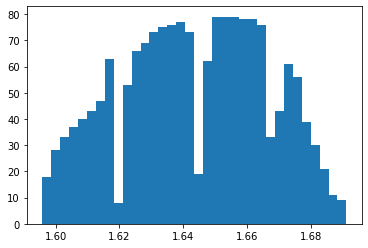

In [126]:
import matplotlib.pyplot as plt
vres = 0.006
num_rings = int((max(sph_pts[:,2])-min(sph_pts[:,2]))/0.004)

pcd_pts = np.asarray(pcd.points)
sph_pts = cart2sph(pcd_pts) # r, az, el
hist = plt.hist(sph_pts[:,2], bins=num_rings)

In [163]:
# We can randomly remove rings
ringidx = np.digitize(sph_pts[:,2], hist[1])
ring_dropout = 0.5 # probability of a ring to be removed
point_dropout = 0.3 # probability of a point to be removed

dropout = np.random.randint(0,num_rings, int(ring_dropout*num_rings))
ring_mask = np.in1d(ringidx, dropout)
pts_mask = np.random.choice(a=[False, True], size=len(sph_pts), p=[point_dropout,1-point_dropout])
mask = pts_mask & ~ring_mask

filtsph = sph_pts[mask]
cartpts = sph2cart(filtsph)

In [164]:
pcd.paint_uniform_color([0.9,0.9,0.9])
o3d.visualization.draw_geometries([convert_to_o3dpcd(cartpts)])

In [795]:
o3d.visualization.draw_geometries([convert_to_o3dpcd(dataset[80]['pts']), boxpts_to_o3dbox(dataset[80]['bbox']), dataset[80]['mesh']])

# Double check that we can load files in

In [ ]:
models = glob.glob(str(save_dir / '*'))

model_idx = 0
model_path = models[model_idx]

complete = [np.load()]

# Cross check with PCN completion data

In [28]:
complete_path = pcn_cars[0].replace('partial', 'complete') 
pcn_pcd = o3d.io.read_point_cloud(complete_path + '.pcd')
o3d.visualization.draw_geometries([pcn_pcd])

In [29]:
len(pcn_cars)

5677

In [26]:
pcn_cars = glob.glob('/SEE-MTDA/data/shapenet/pcn/PCN/train/partial/02958343/*')
pcn_dataset = []

for car_path in pcn_cars:
    data_sample = {}
    complete_path = car_path.replace('partial', 'complete') + '.pcd'
    complete_pcd = o3d.io.read_point_cloud(complete_path)
    
    partial_path = car_path
    views = []
    for i in range(8):
        partial_pcd = o3d.io.read_point_cloud(partial_path + f'/{i:02d}.pcd')
        views.append(partial_pcd)
        
    data_sample['complete'] = complete_pcd
    data_sample['partial'] = views
    pcn_dataset.append(data_sample)

KeyboardInterrupt: 

In [36]:
data_sample = pcn_dataset[0]
data_sample['complete'].paint_uniform_color([0.9,0.9,0.9])

o3d.visualization.draw_geometries([data_sample['complete'], data_sample['partial'][5]])

# Extra

In [99]:
raycasted_pts = np.array(pcd.to_legacy().points)

In [105]:
sph_raypts = cart2sph(raycasted_pts) # (r,az,elevation)

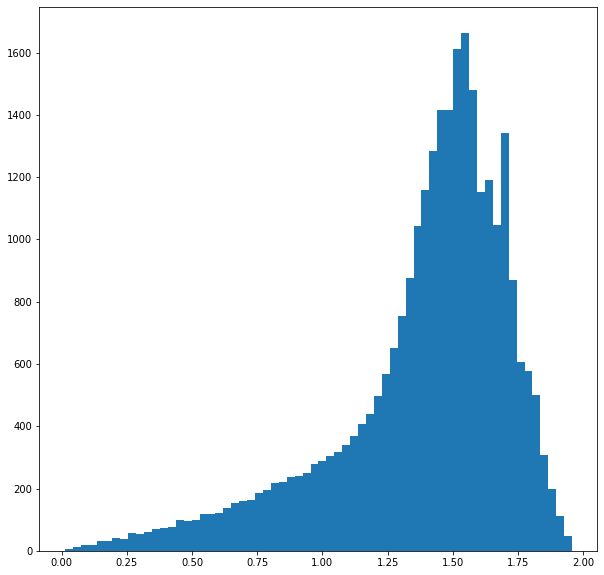

In [110]:
hist = plt.hist(sph_raypts[:,2], bins=64)

In [112]:
hist[1]/np.pi * 180

array([  0.71751546,   2.45842056,   4.19932566,   5.94023076,
         7.68113586,   9.42204096,  11.16294606,  12.90385116,
        14.64475626,  16.38566136,  18.12656647,  19.86747157,
        21.60837667,  23.34928177,  25.09018687,  26.83109197,
        28.57199707,  30.31290217,  32.05380727,  33.79471237,
        35.53561747,  37.27652257,  39.01742767,  40.75833277,
        42.49923787,  44.24014297,  45.98104807,  47.72195317,
        49.46285827,  51.20376337,  52.94466847,  54.68557357,
        56.42647868,  58.16738378,  59.90828888,  61.64919398,
        63.39009908,  65.13100418,  66.87190928,  68.61281438,
        70.35371948,  72.09462458,  73.83552968,  75.57643478,
        77.31733988,  79.05824498,  80.79915008,  82.54005518,
        84.28096028,  86.02186538,  87.76277048,  89.50367558,
        91.24458068,  92.98548578,  94.72639089,  96.46729599,
        98.20820109,  99.94910619, 101.69001129, 103.43091639,
       105.17182149, 106.91272659, 108.65363169, 110.39

# Old code snippets

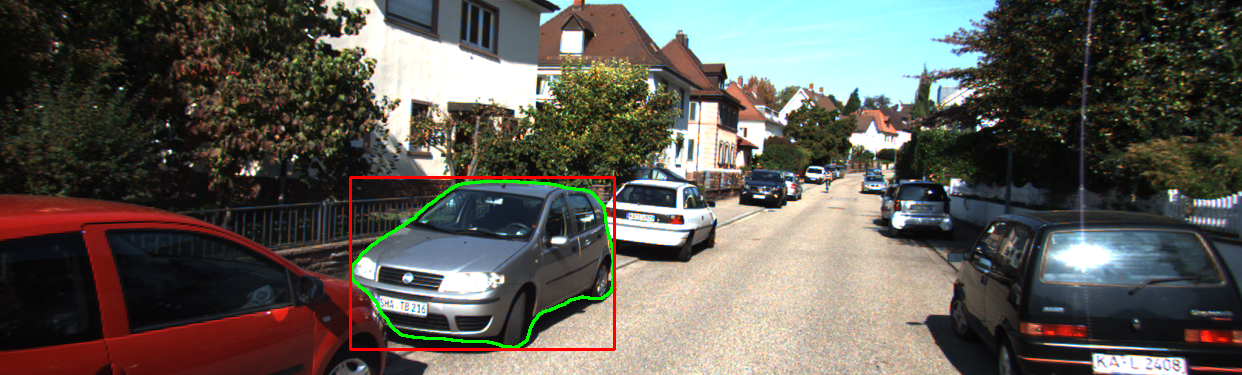

In [412]:
# Load raw lidar cars
data_dir = "/SEE-MTDA/data/kitti/exported/lidar_seg_data/points_in_bbox"
# data_dir = "/SEE-MTDA/data/nuscenes/v1.0-mini/exported/lidar_seg_data/points_in_bbox/CAM_BACK"
# data_dir = "/SEE-MTDA/data/nuscenes/custom_t4025-v3980/exported/lidar_seg_data/points_in_bbox/CAM_BACK"
# data_dir = "/SEE-MTDA/data/baraja/exported/lidar_seg_data/points_in_bbox"

seq_num = "000017"
raw_data = np.fromfile(f"{data_dir}/pointcloud/{seq_num}.bin", dtype=np.float32).reshape((-1,4))
gtlabel = np.fromfile(f"{data_dir}/labels/{seq_num}.label", dtype=np.uint32).reshape((-1,1))
mask = np.argwhere(gtlabel[:,0] == 10)[:,0]

bbox_raw = np.loadtxt(f"{data_dir}/gt_bboxes/{seq_num}.txt")
if np.count_nonzero(bbox_raw) != 0:
    boxpts = o3d.utility.Vector3dVector(bbox_raw)
    o3dbox = o3d.geometry.OrientedBoundingBox().create_from_points(boxpts)
    o3dbox.color = np.array([1,0,0])
    
img = Image.open(f"{data_dir}/image/{seq_num}.png")
img.show()

gtcenter = o3dbox.get_center()
lidarobj_dims = o3dbox.get_max_bound() - o3dbox.get_min_bound()

camera_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=np.array([0,0,0]))

lidarpcd = o3d.geometry.PointCloud()
lidarpcd.points = o3d.utility.Vector3dVector(raw_data[:,:3][mask])
lidarpcd.paint_uniform_color(np.array([1,0,0]))

# Normalize to shapenet
bbox=np.asarray(o3dbox.get_box_points())
yaw = np.arctan2(bbox[4, 1] - bbox[5, 1], bbox[4, 0] - bbox[5, 0]) + np.pi

rotation = np.array([[np.cos(yaw), np.sin(yaw), 0],
                            [-np.sin(yaw), np.cos(yaw), 0],
                            [0, 0, 1]])


In [413]:
lidarpts = np.copy(raw_data[:,:3][mask])

obj_file = models[6] + '/models/model_normalized.obj'
v = load_shapenet(obj_file, num_pts=300000)

# normalize to unit length then scale to same size as car
v = v / (np.max(v, axis=0) - np.min(v,axis=0))
v[:,0] = v[:,0] * o3dbox.extent[0]
v[:,1] = v[:,1] * o3dbox.extent[1]
v[:,2] = v[:,2] * (o3dbox.extent[2]+0.2)  # manual offset for observation only

# # Shapenet scale of model - some max-min gives me a 59m long car??
# v = v / (np.max(v, axis=0) - np.min(v,axis=0))
# v[:,0] = v[:,0] * car_dims[0]
# v[:,1] = v[:,1] * car_dims[1]
# v[:,2] = v[:,2] * car_dims[2]

# # Apply real obj rot and center
v = v @ rotation
v += (gtcenter) # manual offset for observation only; real one will use random offsets

shapenetpcd = o3d.geometry.PointCloud()
shapenetpcd.points = o3d.utility.Vector3dVector(v)
# shapenetpcd.paint_uniform_color(np.array([0,0,1]))

# Stats
shapenetobj_dims = np.linalg.norm(np.asarray(shapenetpcd.get_max_bound()) - np.asarray(shapenetpcd.get_min_bound()))
print(f'Center: {shapenetpcd.get_center()}')
print(f'shapenetobj_dims: {shapenetobj_dims}')
print(f'o3dbox extent: {o3dbox.extent}')
o3d.visualization.draw_geometries([shapenetpcd])

Center: [ 8.19150844  1.17331515 -1.05414399]
shapenetobj_dims: 4.778758768069495
o3dbox extent: [3.68 1.57 1.5 ]


In [414]:
camera = [0,0,0] 
radius = shapenetobj_dims*10000 # Between 800 and 1000 is good
_, pt_map = shapenetpcd.hidden_point_removal(camera, radius)
camvp = shapenetpcd.select_by_index(pt_map)

camera_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=camera)
o3d.visualization.draw_geometries([lidarpcd, camvp, camera_origin])

In [415]:
def cart2sph(points):
    # Phi is up-down, theta is left-right
    x,y,z = points[:,0], points[:,1], points[:,2]
    r = np.linalg.norm(points, axis=1)
    phi = np.arctan2(np.linalg.norm(points[:,:2],axis=1),z) # also = np.arccos(z/r)
    theta = np.arctan2(y,x) # theta in radians, lidar is 360 degrees hence the 3.14 to -3.14 values
    
    return np.concatenate((r[:,np.newaxis],phi[:,np.newaxis],theta[:,np.newaxis]), axis=1)

def sph2cart(points):
    r, theta, phi = points[:,0], points[:,1], points[:,2]
    x = r*np.sin(theta)*np.cos(phi)
    y = r*np.sin(theta)*np.sin(phi)
    z = r*np.cos(theta)
    return np.concatenate((x[:,np.newaxis],y[:,np.newaxis],z[:,np.newaxis]), axis=1)

camvp_np = np.asarray(camvp.points)
densely_sampled_pts_sph = cart2sph(camvp_np)

50


In [416]:
from sklearn.neighbors import NearestNeighbors
import time

ref_pattern_paths = glob.glob(f'/SEE-MTDA/data/shapenet/pcn/ref_pattern_kitti-kitti/*.npy')
ref_patterns = [np.load(path) for path in ref_pattern_paths]
print(len(ref_patterns))

t0 = time.time()
reference_phi_theta = ref_patterns[3]

X = densely_sampled_pts_sph[:,1:3]
Y = reference_phi_theta
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(Y)
indices = indices[:,0]
distances = distances[:,0]

filt_indices = indices[np.where(distances < 0.001)]
dense_filt = densely_sampled_pts_sph[filt_indices]
sampled_obj = sph2cart(dense_filt)

print(time.time() - t0) 

sampled_pcd = convert_to_o3dpcd(sampled_obj)
lidarpcd.paint_uniform_color([0.85, 0.85, 0.85])
o3d.visualization.draw_geometries([sampled_pcd, lidarpcd])

0.2285141944885254


(array([  42.,   59.,  129.,  666., 2055., 2237., 1982., 2540., 2284.,
        2209., 2563., 2516., 2620., 2524., 2740., 2733., 2766., 2622.,
        2691., 2315., 2786., 2291., 2632., 2780., 2646., 2584., 2480.,
        2016., 1639., 1550., 2107., 2524., 1613., 1430., 2076., 2149.,
        2093., 2151., 2028., 1906., 1443., 1198., 2032., 1636., 2710.,
        1249., 1935., 1979., 1163., 1914., 1432., 1867., 1692., 1242.,
        1732., 1677., 1231., 1208., 1663., 1339.,  279., 1269., 1208.,
        1122.]),
 array([1.4958308, 1.503479 , 1.5111272, 1.5187755, 1.5264237, 1.5340719,
        1.5417202, 1.5493684, 1.5570166, 1.5646648, 1.5723131, 1.5799612,
        1.5876094, 1.5952576, 1.6029059, 1.6105541, 1.6182023, 1.6258506,
        1.6334988, 1.641147 , 1.6487952, 1.6564435, 1.6640917, 1.6717399,
        1.6793882, 1.6870364, 1.6946846, 1.7023329, 1.7099811, 1.7176293,
        1.7252775, 1.7329258, 1.7405739, 1.7482221, 1.7558703, 1.7635186,
        1.7711668, 1.778815 , 1.7864633, 1

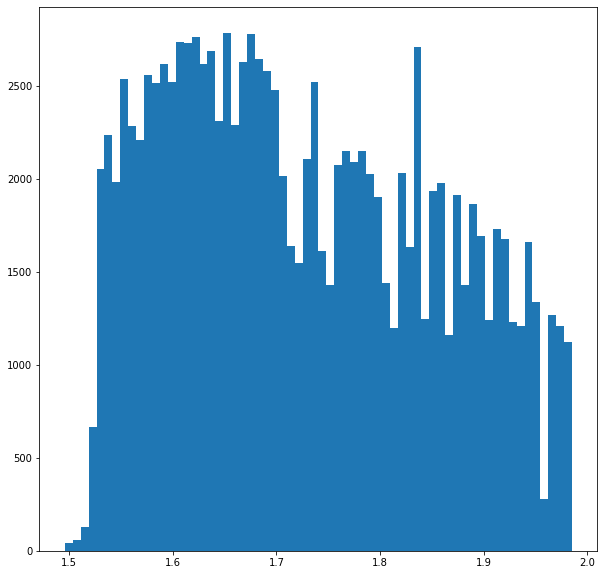

In [417]:
import matplotlib.pyplot as plt

plt.hist(reference_phi_theta[:,0], bins=64) # elevation

In [418]:
reference_phi_theta[:,0][:10] - reference_phi_theta[:,0][1:11]

array([-3.5762787e-07,  5.4836273e-06, -2.1696091e-05, -3.4928322e-05,
        6.3657761e-05,  6.3657761e-05, -6.1631203e-05, -6.1988831e-06,
        1.1205673e-05, -2.8491020e-05], dtype=float32)

In [122]:
reference_phi_theta[:,1][:10] - reference_phi_theta[:,1][1:11]

array([-0.00314853, -0.00314578, -0.00312434, -0.00315842, -0.00313792,
       -0.00154759, -0.00316227, -0.00314678, -0.00312496, -0.00314724],
      dtype=float32)

In [123]:
0.01642424/np.pi * 180

0.9410396337099471

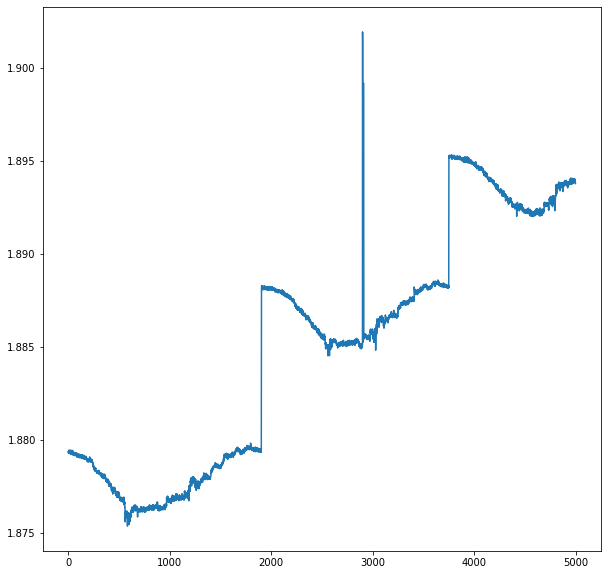

In [465]:
plt.plot(reference_phi_theta[:,0][100000:105000])

In [441]:
one_cycle = reference_phi_theta[:,1][860:2705]
one_cycle_minus1 = reference_phi_theta[:,1][859:2704]
hres = one_cycle-one_cycle_minus1

(array([1.812e+03, 1.400e+01, 5.000e+00, 7.000e+00, 4.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([0.00043344, 0.00825937, 0.01608529, 0.02391122, 0.03173714,
        0.03956307, 0.04738899, 0.05521492, 0.06304084, 0.07086676,
        0.07869269], dtype=float32),
 <BarContainer object of 10 artists>)

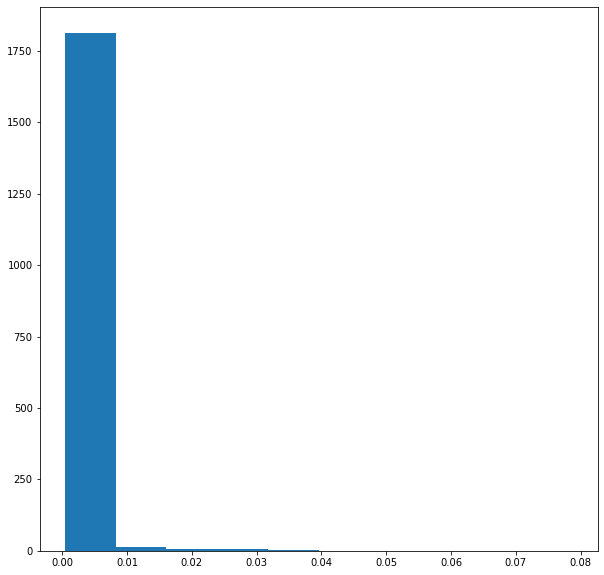

In [442]:
plt.hist(hres)

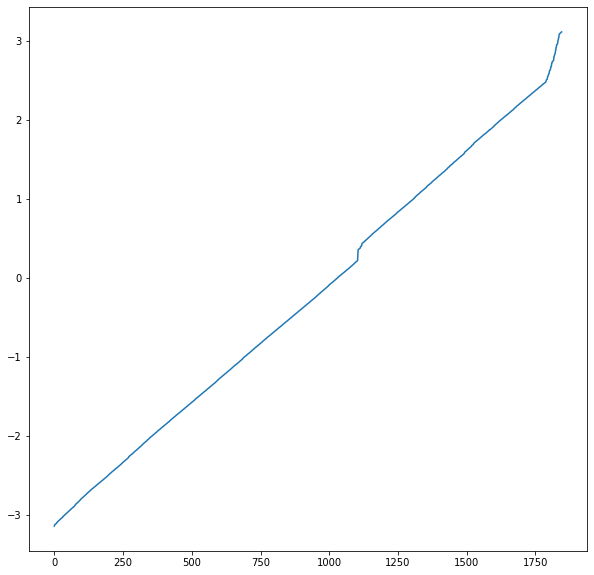

In [439]:
plt.plot(reference_phi_theta[:,1][859:2705])

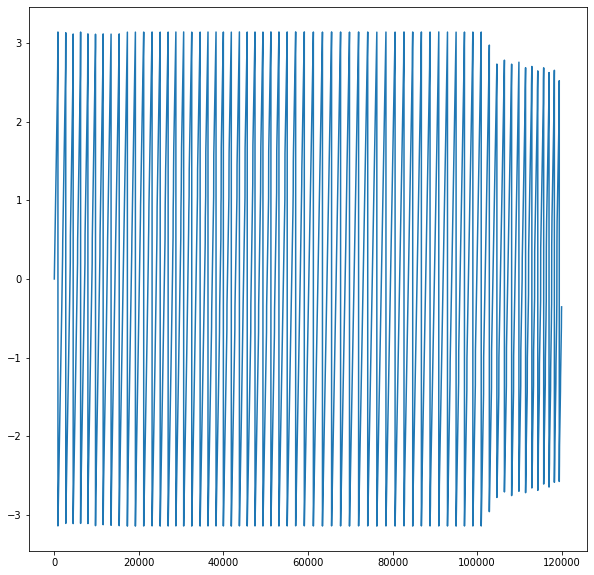

In [420]:
plt.plot(reference_phi_theta[:,1])

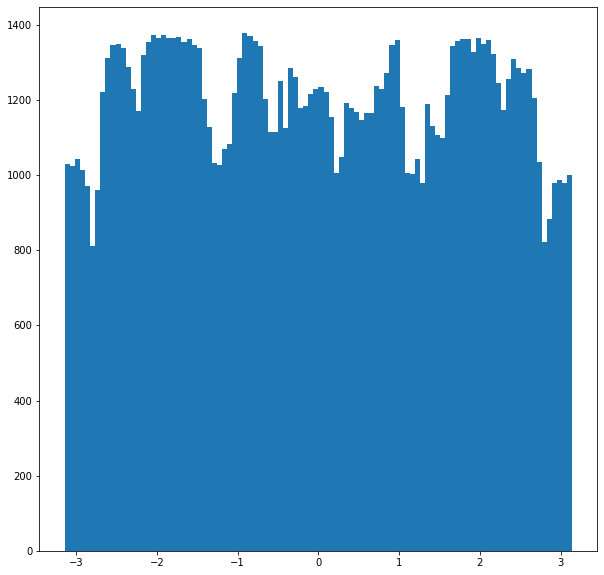

In [126]:
_ = plt.hist(reference_phi_theta[:,1], bins=100) # azimuth

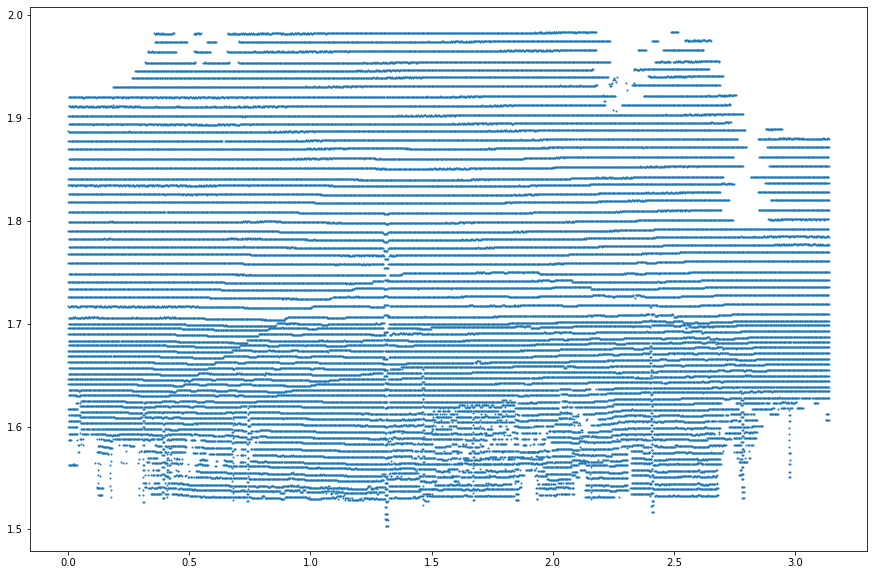

In [129]:
reference_phi_theta = ref_patterns[10]
mask = (reference_phi_theta[:,1] < np.pi) & (reference_phi_theta[:,1] > 0) 
fov = reference_phi_theta[mask]
plt.figure(figsize=(15,10))
plt.scatter(fov[:,1], fov[:,0], s=1)

In [282]:
# from tqdm import tqdm
# x, y, z = [], [], []
# seqs = glob.glob(f"{data_dir}/pointcloud/*.bin")
# for seq in tqdm(seqs, total=len(seqs)):
#     seq_num = seq.split('/')[-1].split('.')[0]
#     bbox_raw = np.loadtxt(f"{data_dir}/gt_bboxes/{seq_num}.txt")
#     if np.count_nonzero(bbox_raw) != 0:
#         boxpts = o3d.utility.Vector3dVector(bbox_raw)
#         o3dbox = o3d.geometry.OrientedBoundingBox().create_from_points(boxpts)
#     x.append(o3dbox.get_center()[0])
#     y.append(o3dbox.get_center()[1])
#     z.append(o3dbox.get_center()[2])

100%|████████████████████████████████████████| 35891/35891 [03:00<00:00, 198.93it/s]


In [299]:
from scipy.stats import norm

(mu, sigma) = norm.fit(adjusted_z)